# Structure of BERT input word embeddings: basic analysis

In this notebook we apply basic techniques of cluster analysis to word embedding vector space and try a method of space structure visualization. These experiments bring us closer to a more general goal: finding concise enough way to describe the structure and basic properties of word embedding spaces, which in its turn influence on sentence embedding results in Transformer architectures.

Cluster analysis is performed in the original space and in lower-dimensional spaces, obtained by PCA and t-SNE. Found clusters are visualized in polar coordinates in subspaces of the original space.

Notebook execution (without initial model downloading) takes less than 10 mins on Intel Core i5 CPU and uses less than 4 GB of RAM.

**Contents**
1. [Load and Prepare Data](#load_data)
1. [Service Functions](#service_functions)
1. [Cluster Analysis](#cluster_analysis)
   1. [Cluster Analysis in the Original Space](#cluster_analysis_original_space)
      1. [Find Clustering Parameters](#orig_clustering_params)
      1. [Properties of Found Clusters](#orig_cluster_props)
   1. [Cluster Analysis in Reduced Space: PCA](#cluster_analysis_pca_space)
      1. [Find Clustering Parameters](#pca_clustering_params)
      1. [Properties of Found Clusters](#pca_cluster_props)
   1. [Cluster Analysis in Reduced Space: t-SNE](#cluster_analysis_tsne_space)
      1. [Find Clustering Parameters](#tsne_clustering_params)
      1. [Properties of Found Clusters](#tsne_cluster_props)
   1. [Compare Clustering Results: Original and t-SNE Spaces](#compare_clustering_results)
1. [Visualize Vector Space Structure](#visualize_vector_space)
   1. [Functions for Coordinate Conversion](#coord_conv_funcs)
   1. [Statistics in Generalized Polar Coordinates](#gen_pol_coords_stat)
   1. [Check Visualization on Toy Datasets](#check_on_toy_datasets)
   1. [Visualize Clusters](#visualize_clusters)
      1. [Clusters Found in the Original Space](#visualize_orig_clusters)
      1. [Clusters Found in t-SNE Reduced Space](#visualize_tsne_clusters)
1. [Conclusions](#final_conclusions)

In [1]:
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize as sklearn_normalize
from transformers import BertTokenizer, BertModel
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import gc  # in some cases manual garbage collecting is necessary

Matplotlib created a temporary cache directory at /tmp/matplotlib-qg651jxj because the default path (/home/yakhno/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Load and Prepare Data <a name="load_data"></a>

As an object for investigation we use pre-trained word embeddings for the input of [BERT model](https://github.com/google-research/bert). Although instead of Google implementation we use [ucased BERT base](https://huggingface.co/bert-base-uncased) model from Hugging Face.

In [2]:
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)

Since we are interested only in input embeddings, we will work only with `model: BertModel => embeddings: BertEmbeddings => word_embeddings: Embedding` from the structure below.

In [3]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

Consequently, from the loaded pre-trained weights we need only the following parts:
* Pre-trained word embedding matrix, which contains all embeddings for vocabulary tokens
* Vocabulary, which is extracted from BERT tokenizer; it will be used to decode embedding vectors back into words when needed

In [4]:
embedding_matrix = model.embeddings.word_embeddings.weight.data.numpy()
print(f"Shape of pre-trained embedding matrix: {embedding_matrix.shape}")
print(f"Size of vocabulary: {len(tokenizer.vocab)}")

Shape of pre-trained embedding matrix: (30522, 768)
Size of vocabulary: 30522


Only `embedding_matrix` and `tokenizer` will be used below.

In [5]:
del model

About 1000 tokens in this implementation are [marked](https://stackoverflow.com/q/62452271) as `[unused#]` and intended for further model domain adaptation with specific vocabulary, so embeddings for them were [randomly initialized and not used in training](https://github.com/google-research/bert/issues/9#issuecomment-434796704). We are excluding these unused tokens from the analysis below. There are also service tokens, like `[CLS]`, `[PAD]`, `[MASK]`, `[SEP]`, `[UNK]`, but their presence is statistically negligible.

In [6]:
UNUSED_TOKEN_IDXS = []  # this array is used later
for token, idx in tokenizer.vocab.items():
    if token.startswith('[unused'):
        UNUSED_TOKEN_IDXS.append(idx)
UNUSED_TOKEN_IDXS.sort()  # sort in ascending order is important for later processing
print(f"Found {len(UNUSED_TOKEN_IDXS)} unused tokens, they will be removed from input data and vocabulary")
print("Remained service tokens in vocabulary: "
      f"{[t for t in tokenizer.vocab.keys() if t.startswith('[') and not t.startswith('[unused') and t.endswith(']')]}")
print()

embedding_matrix = np.delete(embedding_matrix, UNUSED_TOKEN_IDXS, axis=0)
print(f"New shape of input embeddings matrix: {embedding_matrix.shape}")
print(f"New vocabulary size: {len(tokenizer.vocab) - len(UNUSED_TOKEN_IDXS)}")

Found 994 unused tokens, they will be removed from input data and vocabulary
Remained service tokens in vocabulary: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']

New shape of input embeddings matrix: (29528, 768)
New vocabulary size: 29528


Besides of that, [BERT's tokenizer](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer) uses [WordPiece](https://huggingface.co/docs/transformers/tokenizer_summary#wordpiece) algorithm, and its vocabulary contains both subwords and whole words (always in lower case, because model is uncased). Few non-ASCII symbols are also included in the vocabulary.

Here we will mainly investigate only clusters, which are formed by whole English words. As you can see below, this vocabulary is not so small.

In [7]:
whole_words_len = len(
    [
        t for t in tokenizer.vocab.keys()
            if t.isascii() and not t.startswith('##') and not t.endswith('##') and not (t.startswith('[') and t.endswith(']'))
    ]
)
whole_words_len_percent = 100*whole_words_len/(len(tokenizer.vocab) - len(UNUSED_TOKEN_IDXS))
print(f"Whole English words vocabulary size: {whole_words_len} words, which is {whole_words_len_percent:.0f}% of the used vocabulary")

Whole English words vocabulary size: 22749 words, which is 77% of the used vocabulary


## Service Functions  <a name="service_functions"></a>

We put several service functions here to make subsequent explanations more concise. For further results and analysis, you can scroll to the next section.

In [8]:
def embedding2token(embedding_vec, knn_model):
    """
    returns nearest token for embedding vector
    """
    index = knn_model.kneighbors([embedding_vec], return_distance=False)[0]
    # restore original index, because valuse with UNUSED_TOKEN_IDXS were removed (list is sorted in ascending order)
    for idx in UNUSED_TOKEN_IDXS:
        if idx <= index:
            index += 1
    token = tokenizer.convert_ids_to_tokens(index)[0]
    return token

def embeddings2tokens(embedding_vecs, knn_model):
    """
    returns nearest tokens for the sequence of embedding vectors
    """
    indexes = knn_model.kneighbors(embedding_vecs, return_distance=False).flatten()
    # restore original indexes, because valuse with UNUSED_TOKEN_IDXS were removed (list is sorted in ascending order)
    for idx in UNUSED_TOKEN_IDXS:
        add_mask = np.where(idx <= indexes)
        if len(add_mask) > 0:
            indexes[add_mask] += 1
    tokens = tokenizer.convert_ids_to_tokens(indexes)
    return tokens

In [9]:
def word_to_plot_printable(word):
    return word.encode('ascii', 'replace').decode()

def words_to_plot_printable(words):
    return [word.encode('ascii', 'replace').decode() for word in words]

In [10]:
def cluster_count_stats(w2v_vectors, eps_values, metric):
    cluster_counts = []
    noise_counts = []
    biggest_cluster_lens = []
    second_cluster_lens = []
    third_cluster_lens = []
    fifth_cluster_lens = []
    avg_cluster_lens = []
    plt_legend = []
    max_cluster_len = 0
    for eps in tqdm(eps_values):
        dbscan = DBSCAN(eps=eps, metric=metric, min_samples=5, n_jobs=5).fit(w2v_vectors)
        labels = dbscan.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        cluster_lens = []
        for l in set(labels):
            if l == -1:
                continue
            cluster_lens.append(list(labels).count(l))
        cluster_lens.sort(reverse=True)

        cluster_counts.append(n_clusters)
        noise_counts.append(n_noise)
        biggest_cluster_lens.append(cluster_lens[0] if len(cluster_lens) > 0 else -1)
        second_cluster_lens.append(cluster_lens[1] if len(cluster_lens) > 1 else -1)
        third_cluster_lens.append(cluster_lens[2] if len(cluster_lens) > 2 else -1)
        fifth_cluster_lens.append(cluster_lens[4] if len(cluster_lens) > 4 else -1)
        avg_cluster_lens.append(int(np.mean(cluster_lens)) if len(cluster_lens) > 0 else -1)

        if len(cluster_lens) > 4:
            plt.plot(list(range(4, min(40, len(cluster_lens)) + 1)), cluster_lens[3:40])
            max_cluster_len = max(max_cluster_len, max(cluster_lens[3:]))
            plt_legend.append(f"eps: {eps}")

        del dbscan, labels
        gc.collect()

    plt.legend(plt_legend)
    plt.xticks(list(range(4, 41, 2)))
    plt.title(f"Number of clusters for \"{metric}\" metric for different epsilons")
    plt.xlabel("Nth biggest cluster (first 3 not shown)")
    plt.ylabel("Number of elements in Nth biggest cluster")
    plt.show()

    return pd.DataFrame(
        {
            'eps': eps_values, 'clusters': cluster_counts, 'outliers': noise_counts,
            'biggest_cluster': biggest_cluster_lens, 'second_cluster': second_cluster_lens,
            'third_cluster': third_cluster_lens, 'fifth_cluster': fifth_cluster_lens,
            'avg_cluster': avg_cluster_lens,
        }
    )

def get_clusters_sorted_by_size(w2v_vectors, eps_val, metric):
    dbscan = DBSCAN(eps=eps_val, metric=metric, min_samples=5, n_jobs=5).fit(w2v_vectors)
    labels = dbscan.labels_
    
    # Number of clusters in labels, ignoring noise if present
    n_noise = list(labels).count(-1)
    cluster_lens = []
    cluster_elem_idxs = []
    max_cluster_len = 0
    max_cluster_len_label = -1
    for l in set(labels):
        if l == -1:
            continue
        cluster_len = list(labels).count(l)
        cluster_lens.append(cluster_len)
        cluster_elem_idxs.append(np.where(labels == l)[0])
        if max_cluster_len < cluster_len:
            max_cluster_len = cluster_len
            max_cluster_len_label = l
    
    # sort "cluster_lens" in descending order, but correspondingly reorder "cluster_elem_idxs"
    # make tuples -> sort by first elem in tuple -> decouple tuples in two lists
    cluster_lens, cluster_elem_idxs = zip(*sorted(zip(cluster_lens, cluster_elem_idxs), key=lambda x: x[0], reverse=True))
    
    print(f"Number of clusters: {len(cluster_lens)}")
    print(f"Number of points in clusters: {len(w2v_vectors) - n_noise}")
    print("Number of points in clusters, excluding the biggest one: "
          f"{len(w2v_vectors) - list(labels).count(max_cluster_len_label) - n_noise}")
    print(f"Number of noise points: {n_noise}")
    del labels

    return cluster_lens, cluster_elem_idxs

def plot_cluster_size_comparisons(cluster_names, cluster_lens, compare_cluster_count):
    default_figsize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = (20, 5)
    
    plt.bar(
        words_to_plot_printable(cluster_names[:compare_cluster_count]),
        cluster_lens[:compare_cluster_count],
        color ='maroon',
        width=0.4,
    )
    plt.xlabel("Word/subword in the center of clusters")
    plt.ylabel("Number elements in cluster")
    plt.title(f"Sizes of the first {compare_cluster_count} clusters")
    plt.xticks(rotation=90)
    plt.show()
    
    plt.bar(
        words_to_plot_printable(cluster_names[1:compare_cluster_count]),
        cluster_lens[1:compare_cluster_count],
        color ='maroon',
        width=0.4,
    )
    plt.xlabel("Word/subword in the center of clusters")
    plt.ylabel("Number elements in cluster")
    plt.title(f"Sizes of the first {compare_cluster_count - 1} clusters, starting after the biggest one")
    plt.xticks(rotation=90)
    plt.show()
    
    plt.rcParams['figure.figsize'] = default_figsize

def print_cluster_contents(w2v_vectors, cluster_elem_idxs, knn_model, cluster_show_count, max_cluster_print_elems):    
    assert 2*cluster_show_count <= len(cluster_elem_idxs)
    print(f"=========== {cluster_show_count} biggest clusters: ===========")
    for i, cluster_elems in enumerate(cluster_elem_idxs[:cluster_show_count] + cluster_elem_idxs[-cluster_show_count:]):
        if i == cluster_show_count:
            print(f"=========== {cluster_show_count} smallest clusters: ===========")
        cluster_str = f"Cluster with {len(cluster_elems)} elements"
        if len(cluster_elems) > max_cluster_print_elems:
            # if cluster has too many elements, chose only maximal number of them randomly
            cluster_elems = np.random.choice(cluster_elems, size=max_cluster_print_elems, replace=False)
            cluster_str += f" (printing only {max_cluster_print_elems} of them)"
        cluster_tokens = embeddings2tokens(w2v_vectors[cluster_elems], knn_model)
        cluster_str += ":\n" + f"\t{cluster_tokens}"
        print(cluster_str)

## Cluster Analysis <a name="cluster_analysis"></a>

Clusters of close word embedding vectors should correspond to clusters of similar words (existing visualizations from [Tensorflow](https://projector.tensorflow.org/) and [Anvaka](https://github.com/anvaka/word2vec-graph)). We use [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) algorithm to find clusters. To make it work we need to provide neighboring distance value (`eps` variable) and define distance metric. Usually [cosine distance/similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is used for word embeddings, but [word2vec](https://en.wikipedia.org/wiki/Word2vec#Analysis) it is not strongly proved that it is optimal, so we also use Euclidean distance.

We find suitable values of metric and neighboring distance below, based on number and size of found clusters (grid search).

### Cluster Analysis in the Original Space <a name="cluster_analysis_original_space"></a>

#### Find Clustering Parameters <a name="orig_clustering_params"></a>

  0%|          | 0/8 [00:00<?, ?it/s]

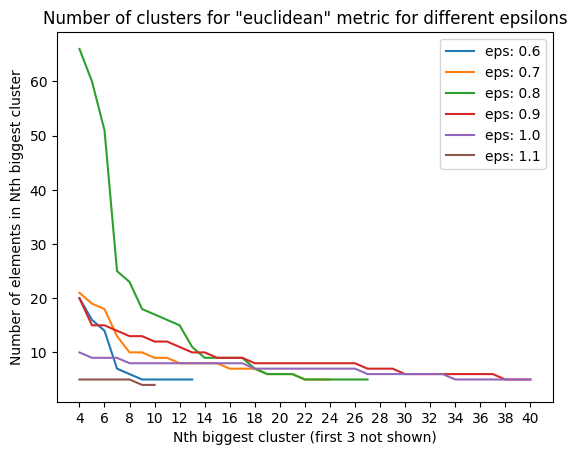

eps  clusters  outliers  biggest_cluster  second_cluster  third_cluster  \
0  0.5         0     29528               -1              -1             -1   
1  0.6        13     29298               60              53             29   
2  0.7        24     28747              335             217             34   
3  0.8        27     28047              580             381            127   
4  0.9        68     26740             2246              53             23   
5  1.0        81     23612             5426              18             16   
6  1.1        10     16419            13063               7              6   
7  1.2         2      8620            20906               2             -1   

   fifth_cluster  avg_cluster  
0             -1           -1  
1             16           17  
2             19           32  
3             60           54  
4             15           41  
5              9           73  
6              5         1310  
7             -1        10454

In [11]:
dbscan_stat_df = cluster_count_stats(
    w2v_vectors=embedding_matrix,
    eps_values=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2],
    metric='euclidean'
)
dbscan_stat_df

  0%|          | 0/10 [00:00<?, ?it/s]

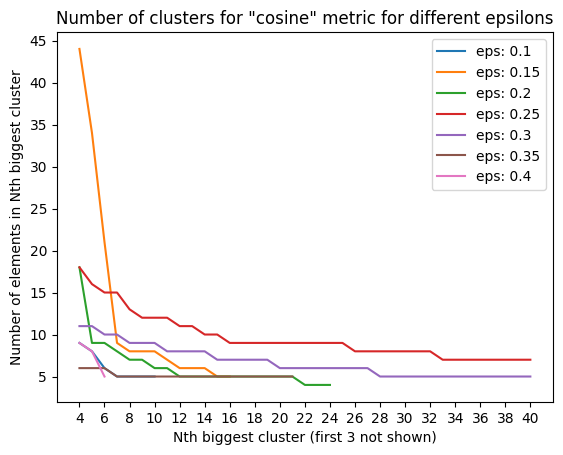

eps  clusters  outliers  biggest_cluster  second_cluster  third_cluster  \
0  0.05         0     29528               -1              -1             -1   
1  0.10        10     29351              108              13             13   
2  0.15        16     28495              321             313            232   
3  0.20        24     27904              982             489             21   
4  0.25        87     26286             2585              28             27   
5  0.30        78     21887             7185              20             11   
6  0.35        21     12759            16653              12             11   
7  0.40         6      4797            24684              13             12   
8  0.45         4      1136            28353              20             14   
9  0.50         1       230            29298              -1             -1   

   fifth_cluster  avg_cluster  
0             -1           -1  
1              8           17  
2             34           64  
3              9           67  
4             16           37  
5             11           97  
6              6          798  
7              8         4121  
8             -1         7098  
9             -1        29298

In [12]:
dbscan_stat_df = cluster_count_stats(
    w2v_vectors=embedding_matrix,
    eps_values=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
    metric='cosine'
)
dbscan_stat_df

**Conclusion**

* Both pairs of "_Euclidean_ metric and `eps=1.0`" and "_cosine_ metric with `eps=0.25`" look suitable, because they have big number of various clusters with more or less equal length
* We choose pair with _Euclidean_ metric for further illustrations, but results for _cosine_ metric are quite similar

In [13]:
BEST_METRIC = 'euclidean'
BEST_EPS = 1.0
# BEST_METRIC = 'cosine'
# BEST_EPS = 0.25

#### Properties of Found Clusters <a name="orig_cluster_props"></a>

Let's take clusters with optimal metric and `eps` value and look at their size and elements.

In [14]:
cluster_lens, cluster_elem_idxs = get_clusters_sorted_by_size(embedding_matrix, BEST_EPS, BEST_METRIC)

Number of clusters: 81
Number of points in clusters: 5916
Number of points in clusters, excluding the biggest one: 490
Number of noise points: 23612


##### Compare Number of Elements

We use the nearest token to the cluster center as a shortcut "name" for the cluster.

In [15]:
knn_model = NearestNeighbors(n_neighbors=1, algorithm='auto', metric=BEST_METRIC).fit(embedding_matrix)
cluster_mean_vectors = [np.mean(embedding_matrix[cluster_elems], axis=0) for cluster_elems in cluster_elem_idxs]
cluster_names = [embedding2token(cluster_mean, knn_model) for cluster_mean in cluster_mean_vectors]

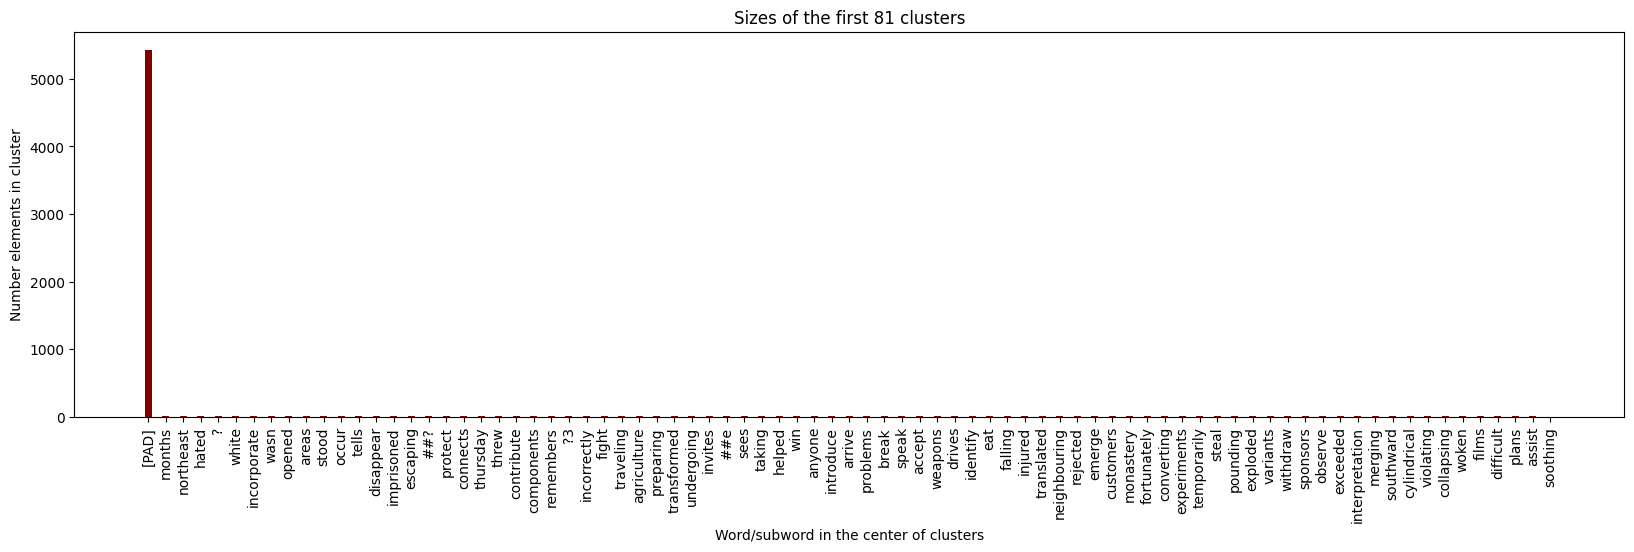

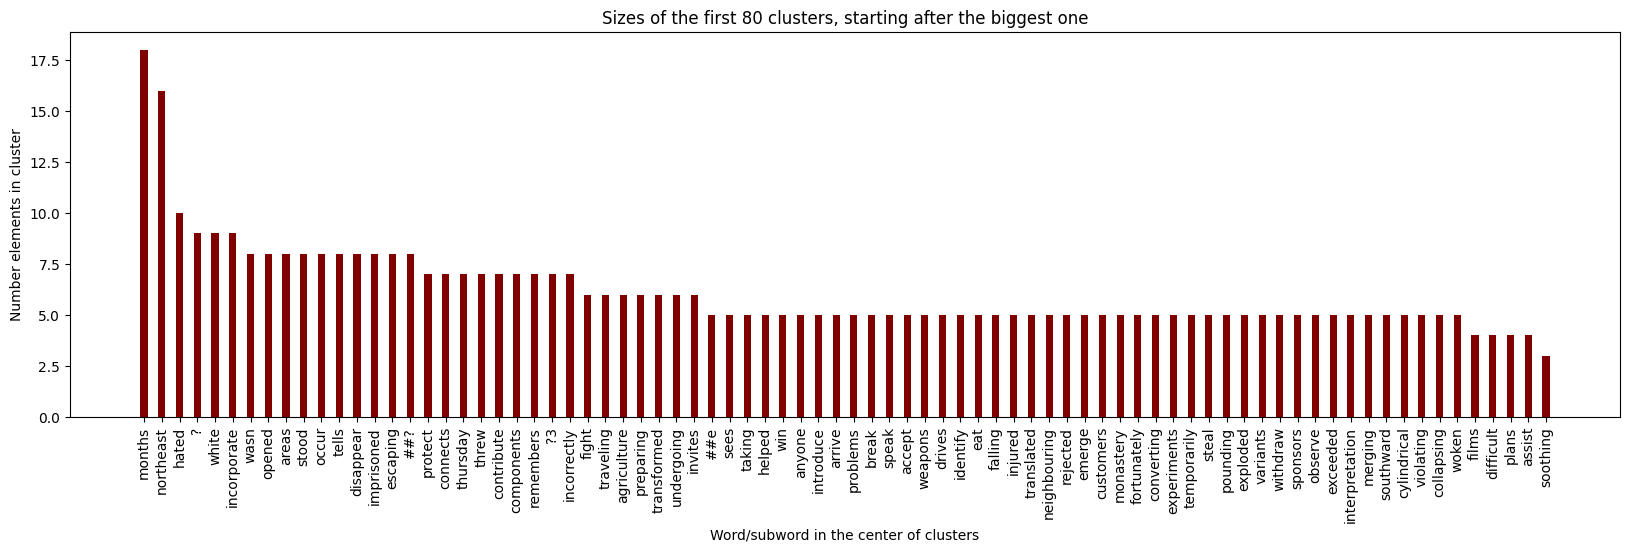

In [16]:
plot_cluster_size_comparisons(cluster_names, cluster_lens, compare_cluster_count=81)

##### Inspect Words in Clusters

To understand clusters better, we print elements from a few biggest and smallest ones.

In [17]:
print_cluster_contents(embedding_matrix, cluster_elem_idxs, knn_model, cluster_show_count=10, max_cluster_print_elems=10)

=========== 10 biggest clusters: ===========
Cluster with 5426 elements (printing only 10 of them):
	['defining', 'อ', '03', '##ז', 'giving', 'ₚ', '##張', '1821', 'nine', '##।']
Cluster with 18 elements (printing only 10 of them):
	['hour', 'hours', 'seconds', 'months', 'year', 'minutes', 'weekend', 'years', 'days', 'weeks']
Cluster with 16 elements (printing only 10 of them):
	['east', 'northeastern', 'northern', 'southwestern', 'northwestern', 'eastern', 'southwest', 'southeast', 'southern', 'western']
Cluster with 10 elements:
	['loved', 'liked', 'hate', 'hated', 'hates', 'dislike', 'disliked', 'hating', 'despised', 'adored']
Cluster with 9 elements:
	['²', '³', '¹', '⁴', '⁵', '⁶', '⁷', '⁸', '⁹']
Cluster with 9 elements:
	['black', 'white', 'red', 'dark', 'blue', 'green', 'brown', 'yellow', 'pink']
Cluster with 9 elements:
	['incorporated', 'integrated', 'integration', 'incorporates', 'incorporate', 'incorporating', 'incorporation', 'integrate', 'integrating']
Cluster with 8 elements

**Conclusion**

* It looks like the first (biggest) cluster contains loosely connected elements. It is interesting that token `[PAD]` appeared in the middle of this cluster.
* Within the clusters, most of words are synonyms or simply different forms of the same word. Although there are several "co-occurring" words with completely different meaning, that became close due to word2vec self-supervised training scheme.

### Cluster Analysis in Reduced Space: PCA <a name="cluster_analysis_pca_space"></a>

[Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) is one of the simplest and most widely used dimensionality reduction methods. We try it to check if it is possible to reduce dimensionality, keeping comparable clustering results.

In [18]:
pca = PCA(n_components=2)  # project from 768 to 2 dimensions
pca_2dim_embeddings = pca.fit_transform(embedding_matrix)
print(f"Original shape: {embedding_matrix.shape}")
print(f"PCA transformed shape: {pca_2dim_embeddings.shape}")

Original shape: (29528, 768)
PCA transformed shape: (29528, 2)


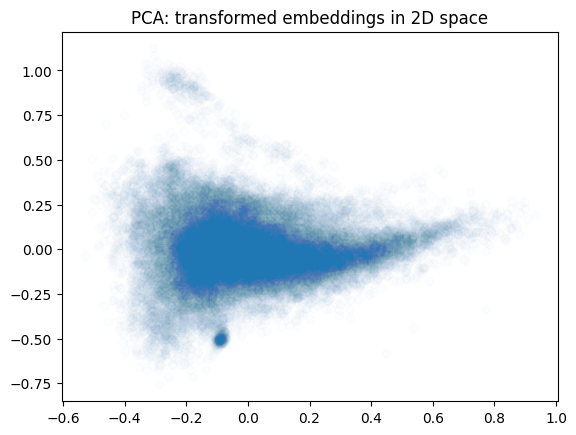

In [19]:
plt.scatter(pca_2dim_embeddings[:, 0], pca_2dim_embeddings[:, 1], alpha=0.01)
plt.title("PCA: transformed embeddings in 2D space")
plt.show()
del pca_2dim_embeddings

To make final PCA transformation we need to find dimensionality of the target space. Below we use [two graphical methods](https://statisticsglobe.com/choose-optimal-number-components-pca): explained variance elbow and threshold for cumulative explained variance.

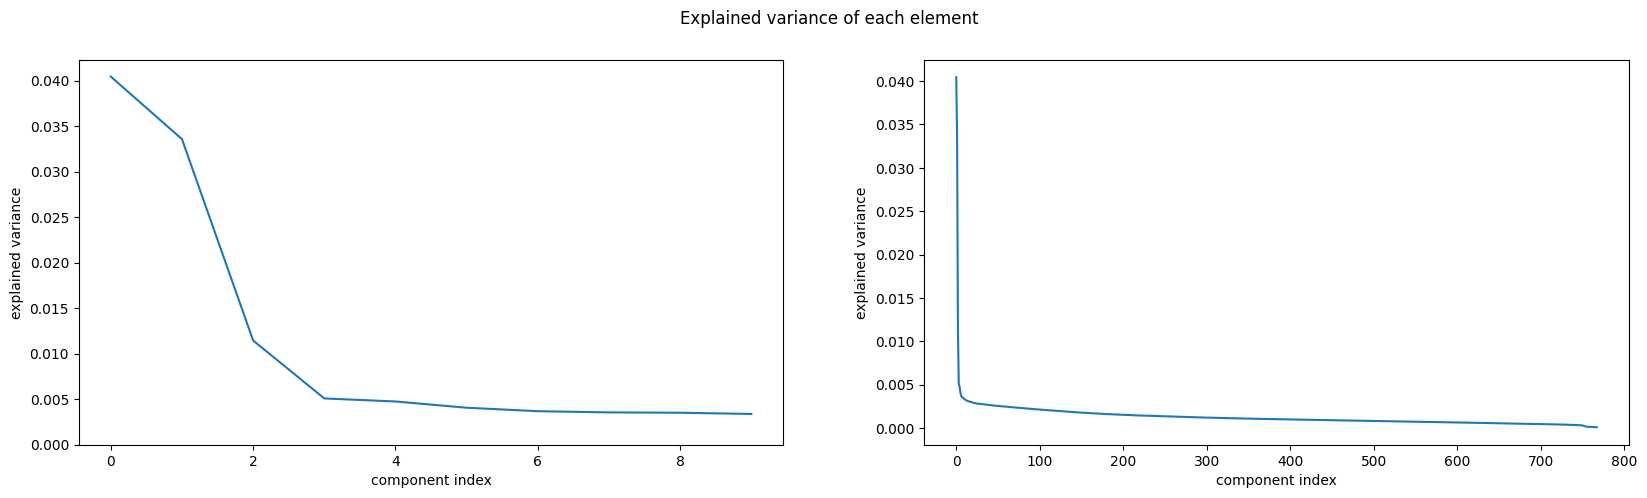

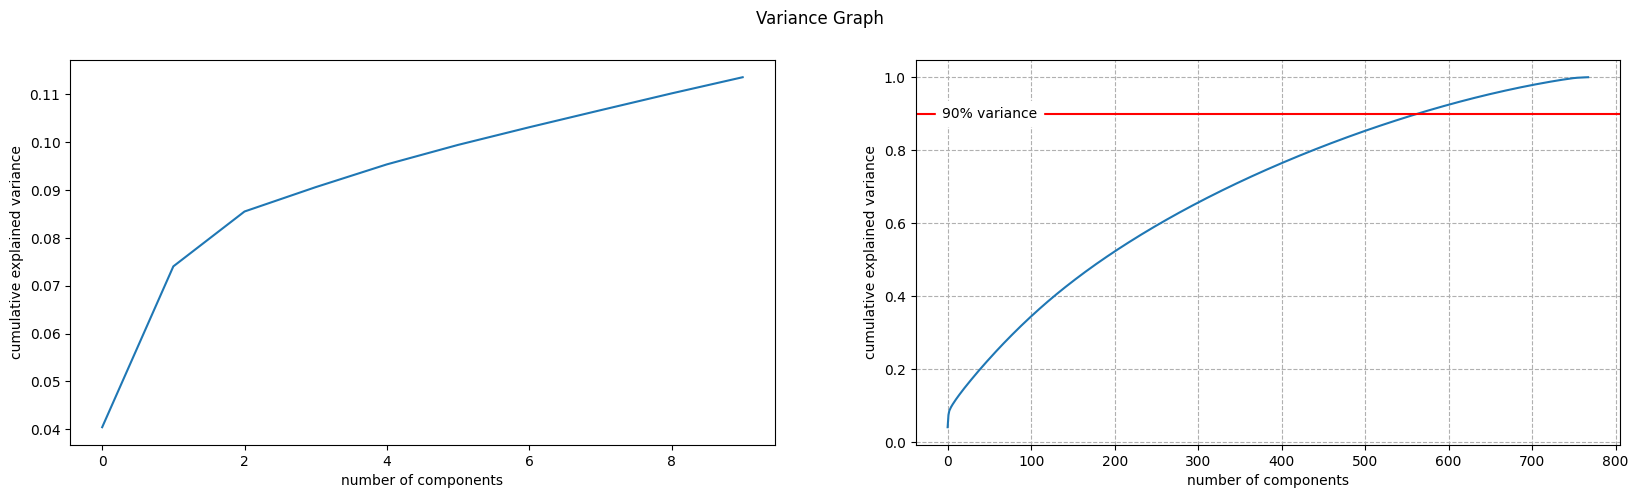

In [20]:
default_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = (20, 5)

#Create PCA version of embedding matrix for graphs
pca_graph = PCA(n_components=768)
pca_graph.fit_transform(embedding_matrix)

fig, axs = plt.subplots(1, 2)

axs[0].plot(pca_graph.explained_variance_ratio_[:10])
axs[0].set_ylim((0, None))  # to compare value drop with zero visually
axs[0].set_xlabel("component index")
axs[0].set_ylabel("explained variance")
axs[1].plot(pca_graph.explained_variance_ratio_)
axs[1].set_xlabel("component index")
axs[1].set_ylabel("explained variance");
plt.suptitle("Explained variance of each element")
plt.show()

fig, axs = plt.subplots(1, 2)

axs[0].plot(np.cumsum(pca_graph.explained_variance_ratio_[:10]))
axs[0].set_xlabel("number of components")
axs[0].set_ylabel("cumulative explained variance")
axs[1].plot(np.cumsum(pca_graph.explained_variance_ratio_))
axs[1].axhline(0.90, c="r")
axs[1].text(50, 0.90, "90% variance", fontsize=10, va='center', ha='center', backgroundcolor='w')
axs[1].grid(True, linestyle='dashed')
axs[1].set_xlabel("number of components")
axs[1].set_ylabel("cumulative explained variance");
plt.suptitle("Variance Graph")
plt.show()

del pca_graph

plt.rcParams['figure.figsize'] = default_figsize

From the plots above:
* Explained variance elbow method gives us target dimension 3 or 4. We will use 4 below.
* Cumulative explained variance method gives target dimension more than 500, which is not applicable for our task. We expect benefit from dimensionality reduction only if "curse of dimensionality" is not manifested in target space, but this is not so for several hundreds of dimensions.

In [21]:
PCA_REDUCED_DIM = 4

pca = PCA(n_components=PCA_REDUCED_DIM)
pca_reduced_embeddings = pca.fit_transform(embedding_matrix)

#### Find Clustering Parameters <a name="pca_clustering_params"></a>

We will use the same "grid search" technique, which we used for the original space. The only difference is that we don't check _cosine_ metric this time, because PCA transformation includes data centering (when mean value is set to zero). _Cosine_ metric depends on the origin of coordinates, which is not preserved this way, while for word embeddings this origin is special point: only zero word2vec vector can't be restored back to vocabulary word by multiplication.

  0%|          | 0/8 [00:00<?, ?it/s]

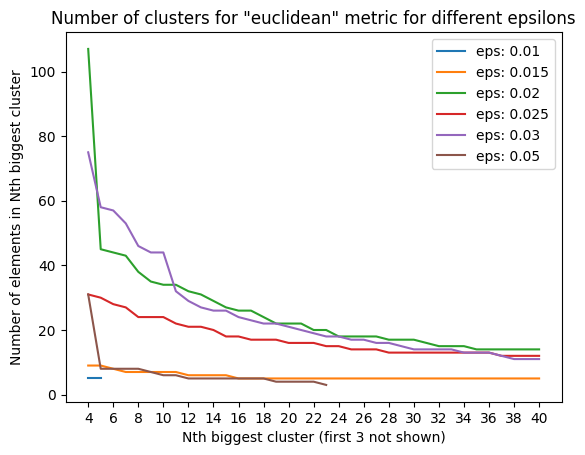

eps  clusters  outliers  biggest_cluster  second_cluster  third_cluster  \
0  0.010         5     29490               16               6              6   
1  0.015        44     29125              150              14              9   
2  0.020       395     25167              694             232            207   
3  0.025       328     17757             9308              59             37   
4  0.030       258     11992            15054             189             94   
5  0.050        23      1540            27557             212             83   
6  0.080         1       114            29414              -1             -1   
7  0.100         1        31            29497              -1             -1   

   fifth_cluster  avg_cluster  
0              5            7  
1              9            9  
2             45           11  
3             30           35  
4             58           67  
5              8         1216  
6             -1        29414  
7             -1        29497

In [22]:
dbscan_stat_df = cluster_count_stats(
    w2v_vectors=pca_reduced_embeddings,
    eps_values=[0.01, 0.015, 0.02, 0.025, 0.03, 0.05, 0.08, 0.1],
    metric='euclidean'
)
dbscan_stat_df

**Conclusion**

* _Euclidean_ metric and `eps=0.015` look suitable to test clustering results, because they have big number of clusters with not so big number of elements.

In [23]:
PCA_BEST_METRIC = 'euclidean'
PCA_BEST_EPS = 0.015

#### Properties of Found Clusters <a name="pca_cluster_props"></a>

Let's take clusters with optimal metric and `eps` value and look at their size and elements.

In [24]:
pca_cluster_lens, pca_cluster_elem_idxs = get_clusters_sorted_by_size(pca_reduced_embeddings, PCA_BEST_EPS, PCA_BEST_METRIC)

Number of clusters: 44
Number of points in clusters: 403
Number of points in clusters, excluding the biggest one: 253
Number of noise points: 29125


##### Compare Number of Elements

We use the nearest token to the cluster center as a shortcut "name" for the cluster.

In [25]:
pca_knn_model = NearestNeighbors(n_neighbors=1, algorithm='auto', metric=PCA_BEST_METRIC).fit(pca_reduced_embeddings)
pca_cluster_mean_vectors = [np.mean(pca_reduced_embeddings[cluster_elems], axis=0) for cluster_elems in pca_cluster_elem_idxs]
pca_cluster_names = [embedding2token(cluster_mean, pca_knn_model) for cluster_mean in pca_cluster_mean_vectors]

plot_cluster_size_comparisons(pca_cluster_names, pca_cluster_lens, compare_cluster_count=45)

##### Inspect Words in Clusters

To understand clusters better, we print elements from a few biggest and smallest ones.

In [26]:
print_cluster_contents(pca_reduced_embeddings, pca_cluster_elem_idxs, pca_knn_model, cluster_show_count=5, max_cluster_print_elems=20)

=========== 5 biggest clusters: ===========
Cluster with 150 elements (printing only 20 of them):
	['##,', '##*', '##^', 'ா', '‘', '##=', '##:', '##∅', '##氵', '##¶', '##;', 'ி', '—', '’', '##糹', 'ಾ', '##〈', '##་', 'ャ', '##李']
Cluster with 14 elements:
	['tugging', 'woven', 'charting', 'adorned', 'rattled', 'punching', 'smoked', 'fatalities', 'flaws', 'transforms', 'yells', 'exasperated', 'undermine', 'unease']
Cluster with 9 elements:
	['loosely', 'coronation', 'sparked', 'privileges', 'assess', 'obligation', 'scratched', 'smoothly', 'curiously']
Cluster with 9 elements:
	['thickness', '1850s', 'perpendicular', 'arithmetic', 'seafood', 'applicant', 'byte', 'coinage', 'concourse']
Cluster with 9 elements:
	['administrators', 'cancellation', 'pots', 'unbelievable', 'erratic', 'dentist', 'tangible', 'rampant', 'respectful']
=========== 5 smallest clusters: ===========
Cluster with 5 elements:
	['distributor', 'accomplishments', 'collingwood', 'accompaniment', 'pasta']
Cluster with 5 eleme

In [27]:
del pca, pca_reduced_embeddings, pca_knn_model

**Conclusion**

* It looks like all the clusters contain loosely connected elements, so vanilla PCA dimensionality reduction makes no benefits for our task.

### Cluster Analysis in Reduced Space: t-SNE <a name="cluster_analysis_tsne_space"></a>

[t-SNE algorithm](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (t-distributed stochastic neighbor embedding) is widely used non-linear dimensionality reduction method. We use it as representative non-linear method to check if it manages to reduce dimensionality, keeping comparable clustering results. Since this algorithm is used for visualizations, its [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) accepts only 2 or 3 as target dimensionality.

In [28]:
tsne = TSNE(n_components=2, learning_rate=50)
tsne_2dim_embeddings = tsne.fit_transform(embedding_matrix)
print(f"Original shape: {embedding_matrix.shape}")
print(f"t-SNE transformed shape: {tsne_2dim_embeddings.shape}")

Original shape: (29528, 768)
t-SNE transformed shape: (29528, 2)


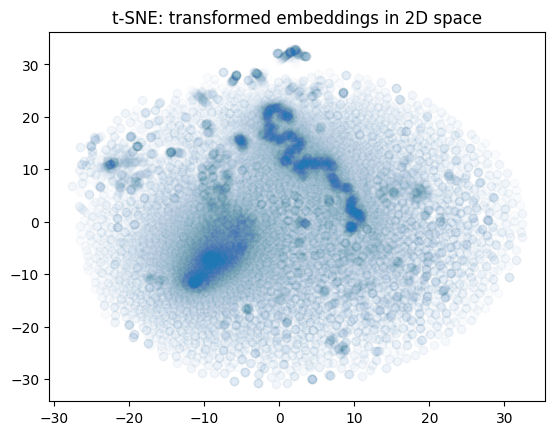

In [29]:
plt.scatter(tsne_2dim_embeddings[:, 0], tsne_2dim_embeddings[:, 1], alpha=0.01)
plt.title("t-SNE: transformed embeddings in 2D space")
del tsne_2dim_embeddings
plt.show()

We use dimensionality 3 below as maximal available option.

In [30]:
TSNE_REDUCED_DIM = 3

# TSNE is computationally intensive, so we decrease its dimensionality by PCA at first
# (see e.g. https://datascience.stackexchange.com/q/56758)
pca = PCA(n_components=50)
pca_intermediate_embeddings = pca.fit_transform(embedding_matrix)

tsne = TSNE(n_components=TSNE_REDUCED_DIM, early_exaggeration=1, n_iter=400, verbose=10)
tsne_reduced_embeddings = tsne.fit_transform(pca_intermediate_embeddings)

del pca, pca_intermediate_embeddings  # we don't plan to restore original vectors

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 29528 samples in 0.001s...
[t-SNE] Computed neighbors for 29528 samples in 0.926s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29528
[t-SNE] Computed conditional probabilities for sample 2000 / 29528
[t-SNE] Computed conditional probabilities for sample 3000 / 29528
[t-SNE] Computed conditional probabilities for sample 4000 / 29528
[t-SNE] Computed conditional probabilities for sample 5000 / 29528
[t-SNE] Computed conditional probabilities for sample 6000 / 29528
[t-SNE] Computed conditional probabilities for sample 7000 / 29528
[t-SNE] Computed conditional probabilities for sample 8000 / 29528
[t-SNE] Computed conditional probabilities for sample 9000 / 29528
[t-SNE] Computed conditional probabilities for sample 10000 / 29528
[t-SNE] Computed conditional probabilities for sample 11000 / 29528
[t-SNE] Computed conditional probabilities for sample 12000 / 29528
[t-SNE] Computed conditional probabilities for sam

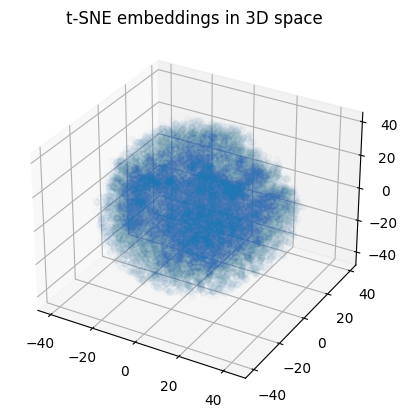

In [31]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=tsne_reduced_embeddings[:, 0], ys=tsne_reduced_embeddings[:, 1], zs=tsne_reduced_embeddings[:, 2], alpha=0.01)
plt.title("t-SNE embeddings in 3D space")
plt.show()

#### Find Clustering Parameters <a name="tsne_clustering_params"></a>

We will use the same "grid search" technique, which we used for the original space. The only difference is that we don't check _cosine_ metric this time, because t-SNE transformation does not preserve origin of coordinates. For word embeddings this origin is special point: only zero word2vec vector can't be restored back to vocabulary word by multiplication.

  0%|          | 0/9 [00:00<?, ?it/s]

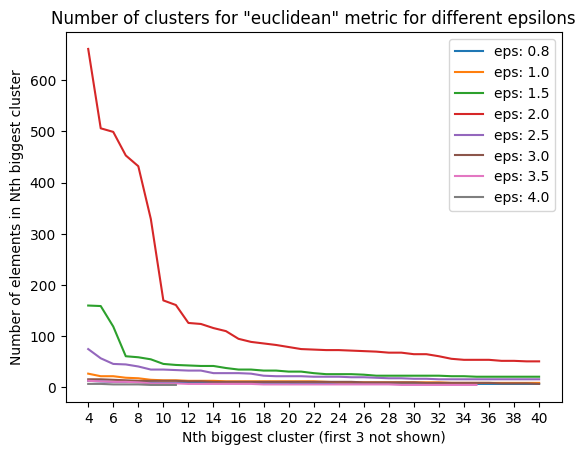

eps  clusters  outliers  biggest_cluster  second_cluster  third_cluster  \
0  0.8       208     28283               18              16             14   
1  1.0       483     26450               52              46             30   
2  1.5      1871     14484              211             202            192   
3  2.0      1195      5156             2784            2097           1504   
4  2.5       285      1763            24382             453            167   
5  3.0        91       824            27973              25             18   
6  3.5        35       449            28825              16             14   
7  4.0        11       179            29278              13             11   
8  5.0         1         6            29522              -1             -1   

   fifth_cluster  avg_cluster  
0             12            5  
1             22            6  
2            159            8  
3            506           20  
4             57           97  
5             16          315  
6             12          830  
7              7         2668  
8             -1        29522

In [32]:
dbscan_stat_df = cluster_count_stats(
    w2v_vectors=tsne_reduced_embeddings,
    eps_values=[0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0],
    metric='euclidean'
)
dbscan_stat_df

**Conclusion**

* _Euclidean_ metric and `eps=1.5` look most suitable to test clustering results, because they have big number of clusters with a not so big number of elements.

In [33]:
TSNE_BEST_METRIC = 'euclidean'
TSNE_BEST_EPS = 1.5

#### Properties of Found Clusters <a name="tsne_cluster_props"></a>

Let's take clusters with optimal metric and `eps` value and look at their size and elements.

In [34]:
tsne_cluster_lens, tsne_cluster_elem_idxs = get_clusters_sorted_by_size(tsne_reduced_embeddings, TSNE_BEST_EPS, TSNE_BEST_METRIC)

Number of clusters: 1871
Number of points in clusters: 15044
Number of points in clusters, excluding the biggest one: 14833
Number of noise points: 14484


##### Compare Number of Elements

We use the nearest token to the cluster center as a shortcut "name" for the cluster.

In [35]:
tsne_knn_model = NearestNeighbors(n_neighbors=1, algorithm='auto', metric=TSNE_BEST_METRIC).fit(tsne_reduced_embeddings)
tsne_cluster_mean_vectors = \
    [np.mean(tsne_reduced_embeddings[cluster_elems], axis=0) for cluster_elems in tsne_cluster_elem_idxs]
tsne_cluster_names = [embedding2token(cluster_mean, tsne_knn_model) for cluster_mean in tsne_cluster_mean_vectors]

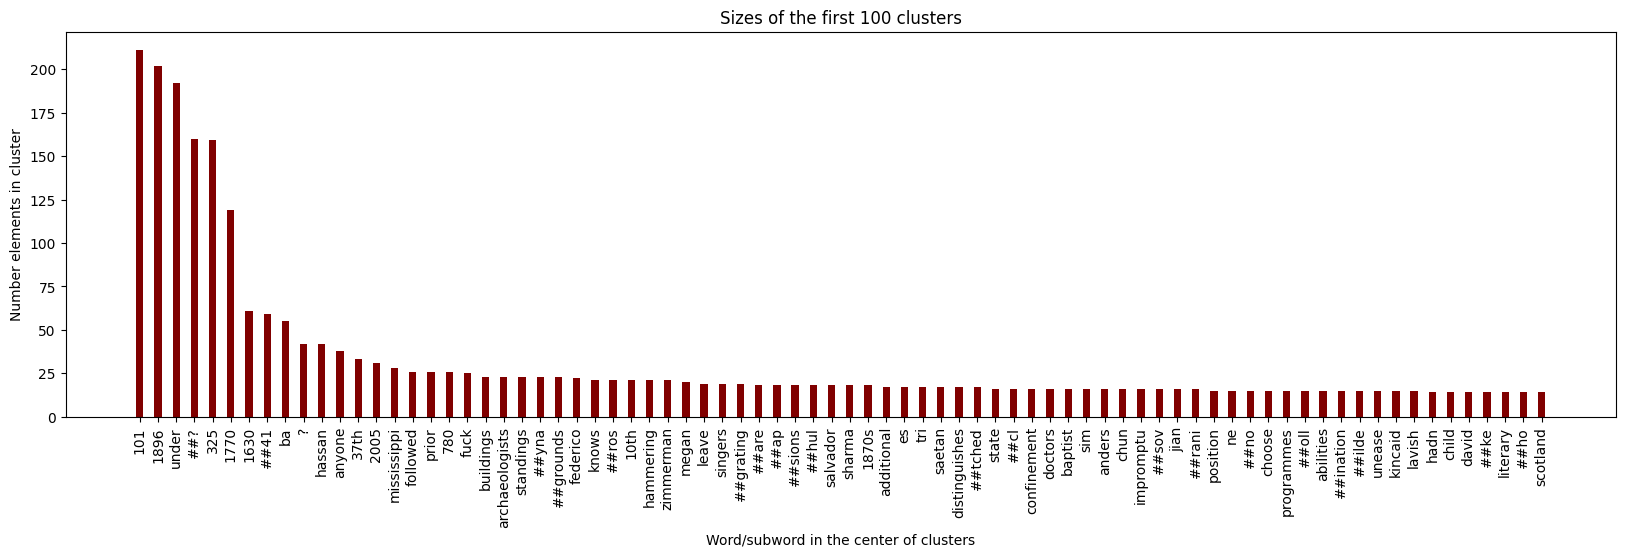

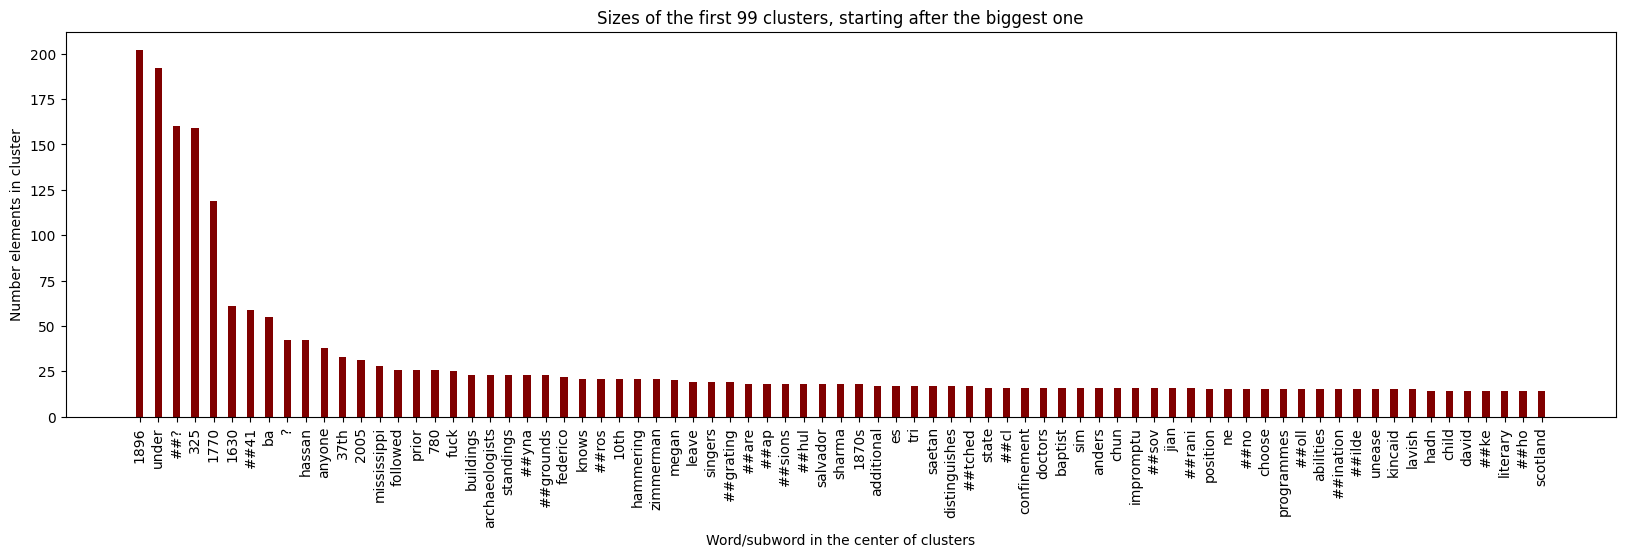

In [36]:
plot_cluster_size_comparisons(tsne_cluster_names, tsne_cluster_lens, compare_cluster_count=100)

##### Inspect Words in Clusters

To understand clusters better, we print elements from a few biggest and smallest ones.

In [37]:
print_cluster_contents(tsne_reduced_embeddings, tsne_cluster_elem_idxs, tsne_knn_model, cluster_show_count=10, max_cluster_print_elems=20)

=========== 10 biggest clusters: ===========
Cluster with 211 elements (printing only 20 of them):
	['106', '212', '4', '6', '210', '37', '58', '97', '240', '69', '92', '107', '230', '154', '207', '147', '219', '105', '148', '56']
Cluster with 202 elements (printing only 20 of them):
	['1968', '1938', '1962', '1946', '1935', '1849', '1922', '1859', '1838', '1857', '1916', '1986', '1841', 'ode', '1984', '1887', '1821', 'kaiser', '1822', 'wills']
Cluster with 192 elements (printing only 20 of them):
	['sometimes', '"', 'the', 'set', 'like', 'usually', 'may', 'let', 'me', 'next', 'that', 'around', 'know', 'especially', 'another', 'while', 'though', 'things', 'with', 'within']
Cluster with 160 elements (printing only 20 of them):
	['‒', '##অ', '##‐', '##=', '”', '##⇒', '場', '##…', '##<', '禾', '##‖', '##」', 'ᆨ', '忄', 'ᅴ', '##´', 'ா', 'ර', '##မ', '‐']
Cluster with 159 elements (printing only 20 of them):
	['172', '415', '249', '460', '357', '178', '312', '309', '279', '332', '189', '232', '2

**Conclusion**

* It looks like the first (biggest) cluster contains elements, which are not closely related, but they still can occur in similar word context.
* Most of the rest clusters look properly, so t-SNE method managed to keep clusters in reduced dimensionality to 3. However we need to compare them with results from the original space to make sure that clusters look similar.

In [38]:
del tsne, tsne_reduced_embeddings, tsne_knn_model

### Compare Clustering Results: Original and t-SNE Spaces <a name="compare_clustering_results"></a>

We use [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index) for comparison, and state that clusters are similar if this index is not less than `0.1`.

In [39]:
similar_tsne_clusters = []
length_coeffs = []
for orig_idx, orig_elems in enumerate(cluster_elem_idxs):
    max_jaccard_index = 0.1
    similar_cluster_idx = None
    for tsne_idx, tsne_elems in enumerate(tsne_cluster_elem_idxs):
        jaccard_index = len(set(orig_elems) & set(tsne_elems)) / len(set(orig_elems) | set(tsne_elems))
        if jaccard_index >= max_jaccard_index and tsne_idx not in similar_tsne_clusters:
            # result will depend on order of clusters and order of loops, but let's keep it simple for estimation
            max_jaccard_index = jaccard_index
            similar_cluster_idx = tsne_idx
    if similar_cluster_idx is not None:
        similar_tsne_clusters.append(similar_cluster_idx)
        if orig_idx > 0 and similar_cluster_idx > 0:  # let's skip too big first clusters with losely connected words
            length_coeffs.append(len(orig_elems) / len(tsne_cluster_elem_idxs[similar_cluster_idx]))

print(f"Number of original clusters: {len(cluster_elem_idxs)}")
print(f"Number of t-SNE clusters: {len(tsne_cluster_elem_idxs)}")
print(f"Estimated number of similar clusters between them: {len(similar_tsne_clusters)}")
print(f"Estimated percents of similar original clusters: {100*len(similar_tsne_clusters)/len(cluster_elem_idxs):.2f}%")
print(f"Estimated percents of similar t-SNE clusters: {100*len(similar_tsne_clusters)/len(tsne_cluster_elem_idxs):.2f}%")
print(f"Estimated length relation between original and t-SNE clusters: {100*np.array(length_coeffs).mean():.2f}%")

Number of original clusters: 81
Number of t-SNE clusters: 1871
Estimated number of similar clusters between them: 61
Estimated percents of similar original clusters: 75.31%
Estimated percents of similar t-SNE clusters: 3.26%
Estimated length relation between original and t-SNE clusters: 88.49%


**Conclusion**

* Most of clusters in the original and t-SNE spaces are similar, so t-SNE can be used in this case to make cluster analysis easier.
* Moreover, t-SNE finds big number of clusters, which were not found in the original space due to the curse of dimensionality.
* t-SNE clusters are longer on average than the original ones, which can mean that there are much more unseen connections between words in the original space. Although it also can be t-SNE artifact or difference between DBSCAN's `eps` for those clustering cases.

## Visualize Vector Space Structure <a name="visualize_vector_space"></a>

To find more characteristics of the embedding space, besides of the found clusters, we try to visualize it with our own method. We don't want to apply general dimensionality reduction methods, because out of clusters they [have artifacts](https://distill.pub/2016/misread-tsne/), which can be hard to identify and interpret.

Our method uses "polar" coordinates (generalized on higher dimensions), because they are natural for word embeddings: vocabulary probabilities vector is restored from the embedding by multiplication on matrix. Due to that "angle" of vector corresponds to word domain area, and vector's "length/radius/amplitude" is proportional to the level of output "probability".

Furthermore, we don't expect any noticeable manifestations of word clustering or other interconnections in raw embedding coordinates, which is illustrated by the histograms below. Averaged distribution of raw components is very smooth, without noticeable artifacts.

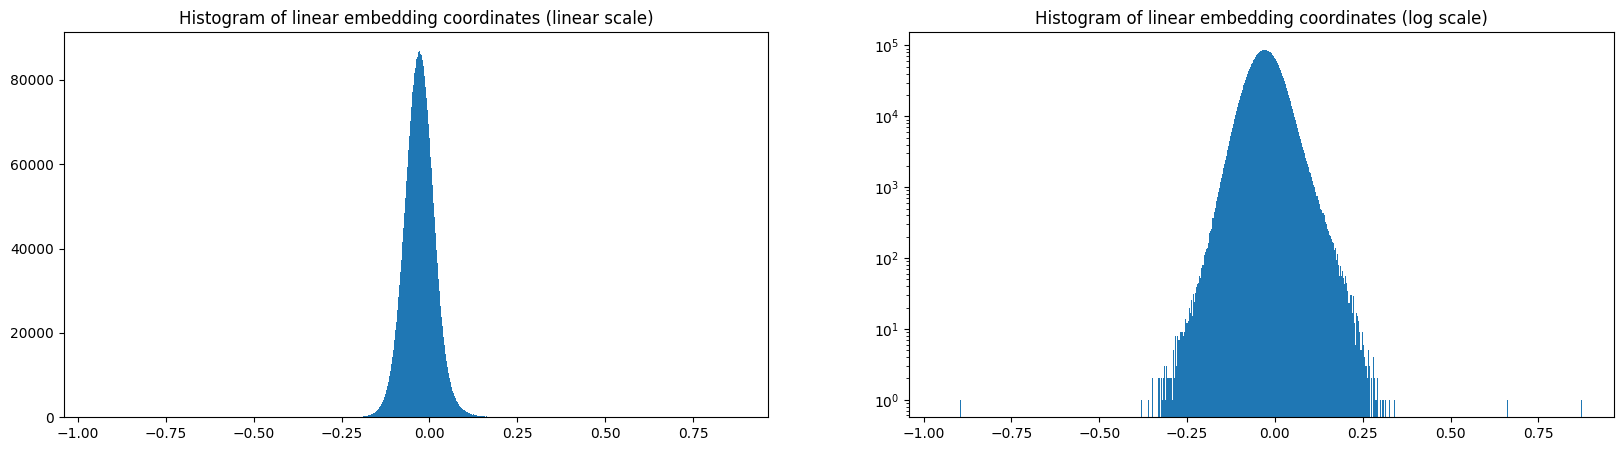

In [40]:
default_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = (20, 5)

fig, axs = plt.subplots(1, 2)

# arguments are passed to np.histogram
axs[0].hist(embedding_matrix.flatten(), bins='auto')
axs[0].set_title("Histogram of linear embedding coordinates (linear scale)")

axs[1].hist(embedding_matrix.flatten(), bins='auto')
axs[1].set_yscale('log')
axs[1].set_title("Histogram of linear embedding coordinates (log scale)")

plt.show()

plt.rcParams['figure.figsize'] = default_figsize

Moving to generalized polar coordinates requires definition of vector "length" and "angle". Defining vector length is not a problem in any metric, we calculate it as Euclidean length. However angle is 2D concept, so it requires a plane and a direction to zero (so it will describe angle between zero direction on plane and projection of the vector on it). We use PCA method to split the original space on planes, which are formed by $\{{PCA}_{i}, {PCA}_{i+1}\}_{i=1}^{d-1} \cup \{{PCA}_{d}, {PCA}_{1}\}$ vector pairs as coordinate system (where ${PCA}_{i}$ is $i$-th PCA eigenvector, and first tuple vector is the zero direction). The origin remains unchanged during this transformation, which is important for results interpretation.

As a result, each vector from the original space $\{x_i\}_{i=1}^{d}$ is converted to  $\{r, \{{\phi}_{i}\}_{i=1}^{d}\}$, where $r$ - vector length, ${\phi}_{i}$ - angle in $\{{PCA}_{i}, {PCA}_{i+1}\}$ plane. Last angle is a bit redundant, as now vector is described by $d+1$ values, but it is kept for concept simplicity.

### Functions for Coordinate Conversion <a name="coord_conv_funcs"></a>

In [41]:
def embeddings2lengths(embeddings, origin_point):
    return np.linalg.norm(embeddings - origin_point, axis=1)

def angle_between(vectors, axis):
    """ Returns angles in radians between each of input vectors and single axis
    """
    # scale all inputs to unit vectors
    vectors_u = sklearn_normalize(vectors, axis=1, norm='l2')
    axis_u = axis / np.linalg.norm(axis)

    return np.arccos(np.clip(np.dot(vectors_u, axis_u), -1.0, 1.0))

def embeddings2angles(embeddings, orthogonal_axes):
    """ For each input embedding in the original space returns array of angles between
        this embedding and each axis from `orthogonal_axes` array; i-th angle is calculated
        in the plane, formed by i-th and (i+1)-th axes.

        Since `angle_between()` function returns closest angle between vector and i-th axis
        (from 0 to `pi`), we correct it, depending on the projection on (i+1)-th axis. This
        allows to restore full angle from 0 to 2*`pi` on the plane.
    """
    angles_by_axes = []
    for axis_idx in range(orthogonal_axes.shape[0]):
        current_axis = orthogonal_axes[axis_idx]
        if axis_idx < orthogonal_axes.shape[0] - 1:
            next_axis = orthogonal_axes[axis_idx + 1]
        else:
            # if last index reached, use first axis
            next_axis = orthogonal_axes[0]
        
        a1 = angle_between(embeddings, next_axis)
        a2 = angle_between(embeddings, current_axis)

        change_idxs = np.where(a1 <= np.pi / 2)[0]
        a2[change_idxs] = (np.pi * 2) - a2[change_idxs]

        angles_by_axes.append(a2)

    return np.array(angles_by_axes)

### Statistics in Generalized Polar Coordinates <a name="gen_pol_coords_stat"></a>

With statistics of only vector lengths, it is already possible to check some properties of the original vector space. For example, if all the points are located in a _single_ cloud, which is _far_ from the origin (at least does not include it). To check this hypothesis, we need to calculate "mean vector" in the original space - in case of single cloud it will be at the cloud center. Then we can calculate length of this vector and compare it with the distribution of lengths of all vectors in space: for the single cloud, which is far from the origin, length of mean vector should be close to the average length of all other vectors. If it is not so, points are distributed around the origin in different directions (probably, multiple clouds).

Additionally, we can recalculate vector lengths, relative to the mean vector (mean point instead of the origin). If we get lengths, which are less than length of the mean vector, then it is a single cloud out of the origin. In the other case, no statement can be made: the origin can be either in or out of the cloud.

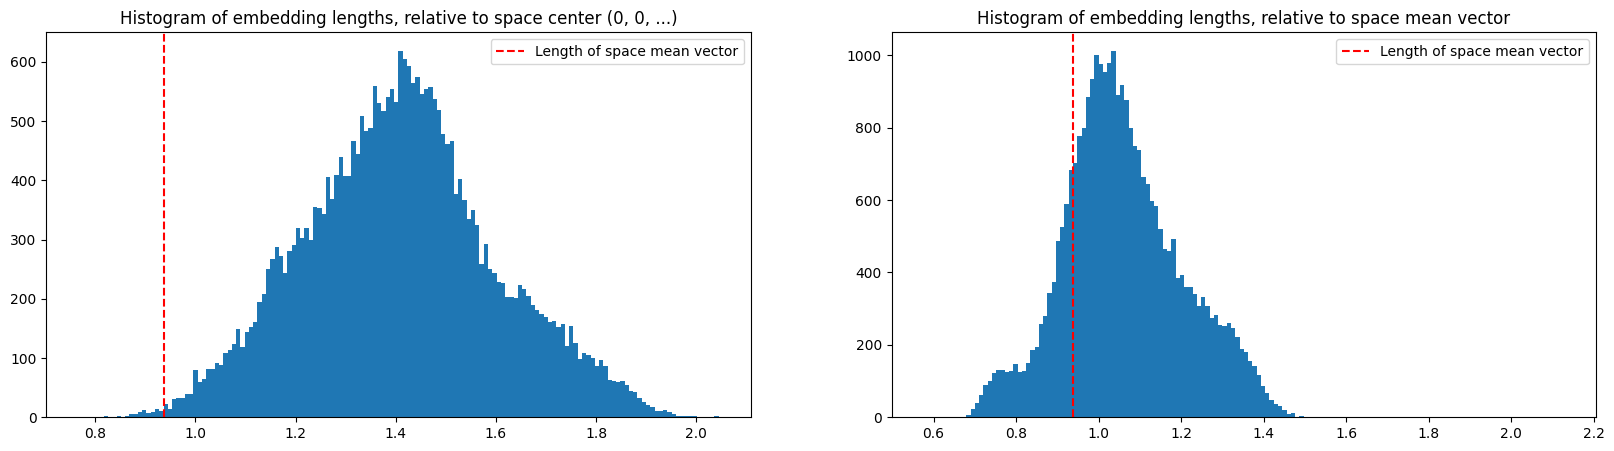

In [42]:
default_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = (20, 5)

fig, axs = plt.subplots(1, 2)

space_center = np.zeros(embedding_matrix.shape[1])
embedding_lengths = embeddings2lengths(embedding_matrix, space_center)

# arguments are passed to np.histogram
axs[0].hist(embedding_lengths, bins=150)
axs[0].set_title("Histogram of embedding lengths, relative to space center (0, 0, ...)")

mean_vector = np.mean(embedding_matrix, axis=0)
embedding_lengths = embeddings2lengths(embedding_matrix, mean_vector)

axs[1].hist(embedding_lengths, bins=150)
axs[1].set_title("Histogram of embedding lengths, relative to space mean vector")

mean_vector_length = embeddings2lengths([mean_vector], space_center)[0]
axs[0].axvline(x=mean_vector_length, color='red', ls='--', label="Length of space mean vector")
axs[0].legend()
axs[1].axvline(x=mean_vector_length, color='red', ls='--', label="Length of space mean vector")
axs[1].legend()

plt.show()

plt.rcParams['figure.figsize'] = default_figsize

**Conclusion**

* Points in the original space are distributed around the origin in different directions, it is not a single cloud in a particular direction

By the way, using simple condition relative vector lengths, we can detect single outlier token with enormously large vector length: it is special `[CLS]` token, which is used in BERT at the beginning of input.

In [43]:
embeddings2tokens(embedding_matrix[embedding_lengths > 2], knn_model)

['[CLS]']

At the next step we can stand at the origin and "look around" in different PCA-defined planes to determine distribution of points in them.

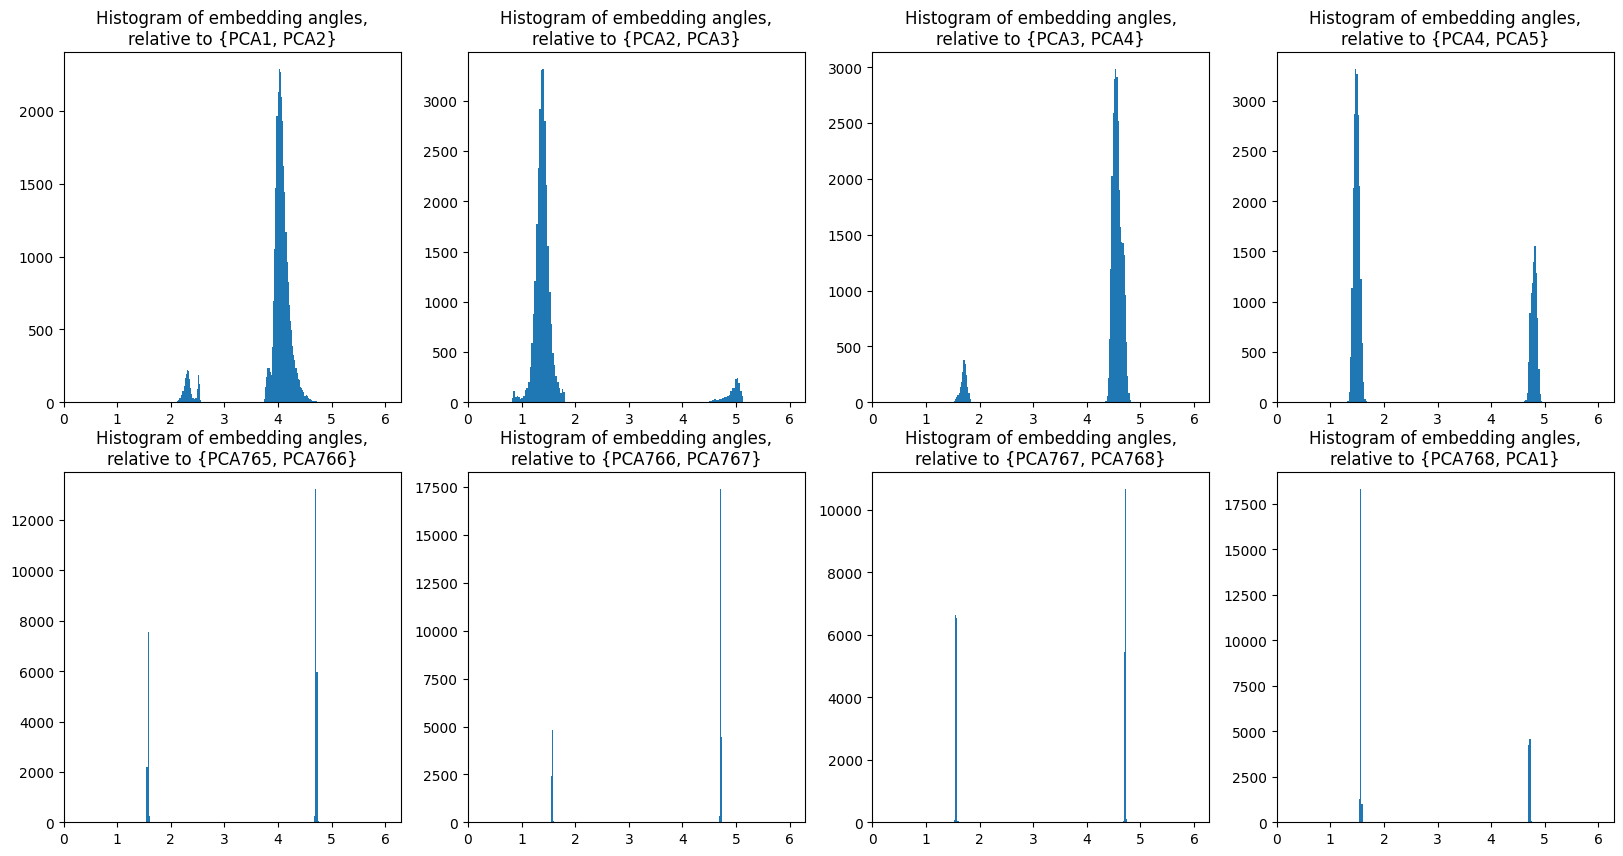

In [44]:
ANGLE_PLT_COUNT = 4

default_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = (20, 10)

fig, axs = plt.subplots(2, ANGLE_PLT_COUNT)

# do not reduce the components to get all dimensions (hold the original shape)
pca = PCA(n_components=embedding_matrix.shape[1])
pca.fit(embedding_matrix)

assert 2*(ANGLE_PLT_COUNT + 1) <= pca.components_.shape[0]
embedding_angles = embeddings2angles(
    embedding_matrix,
    orthogonal_axes=np.array(list(pca.components_[:(ANGLE_PLT_COUNT + 1)]) + list(pca.components_[-(ANGLE_PLT_COUNT + 1):]))
)

for i in range(ANGLE_PLT_COUNT):
    axs[0, i].hist(embedding_angles[i], bins=150)
    axs[0, i].set_title(f"Histogram of embedding angles,\nrelative to {{PCA{i + 1}, PCA{i + 2}}}")
    axs[0, i].set_xlim((0, np.pi * 2))

for i in range(ANGLE_PLT_COUNT):
    axs[1, i].hist(embedding_angles[-(ANGLE_PLT_COUNT + 1) + i], bins=150)
    ax_i = pca.components_.shape[0] - ANGLE_PLT_COUNT + i
    axs[1, i].set_title("Histogram of embedding angles,\n"
                        f"relative to {{PCA{ax_i + 1}, PCA{ax_i + 2 if ax_i + 2 <= pca.components_.shape[0] else 1}}}")
    axs[1, i].set_xlim((0, np.pi * 2))

plt.show()

plt.rcParams['figure.figsize'] = default_figsize

**Conclusion**

* It looks like there are two main clouds in the original space, and they are directed in opposite directions in various projections, except the first one. Difference between cloud angles is about $\pi$ ($180^{\circ}$).
* PCA sorts its components by decrease of variation in linear coordinates. It looks like it is reflected in angle variations as well: they are much more narrower at the last components.

To get more information length and angle statistics can be joined on 2D distributions below.

In [45]:
def draw_2d_histograms(lengths, angles, title, finalize_plot=True):
    ax1 = plt.gcf().add_subplot(1, 2, 1)
    ax1.hist2d(
        angles,
        lengths,
        bins=(400, 200),
        range=((0, 2*np.pi), (lengths.min(), lengths.max())),
        norm='symlog',
    )
    ax1.set_xlabel("Angles (radian)")
    ax1.set_xlim((0, np.pi * 2))
    ax1.set_ylabel("Lengths")
    ax1.set_title(title)

    ax2 = plt.gcf().add_subplot(1, 2, 2, projection='polar')
    hist_vals, new_angles, new_lengths = np.histogram2d(
        angles,
        lengths,
        bins=(400, 200),
        range=((0, 2*np.pi), (lengths.min(), lengths.max())),
    )
    ax2.pcolormesh(new_angles, new_lengths, hist_vals.transpose(), norm='symlog')
    ax2.set_title(title)

    if finalize_plot:
        plt.show()
    else:
        return ax1, ax2

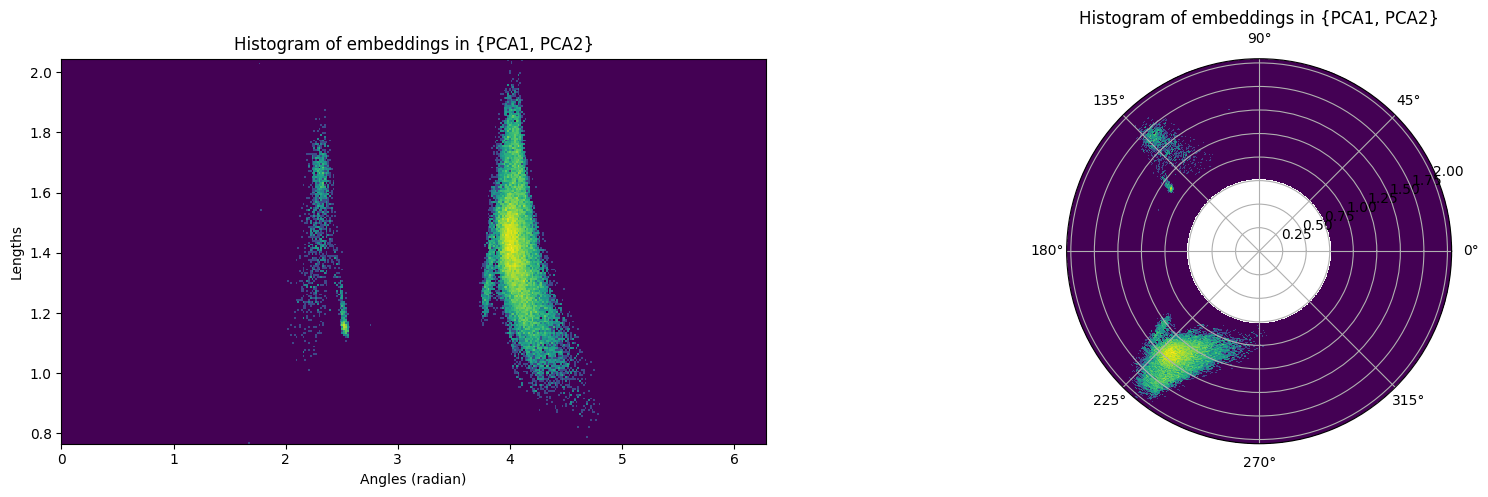

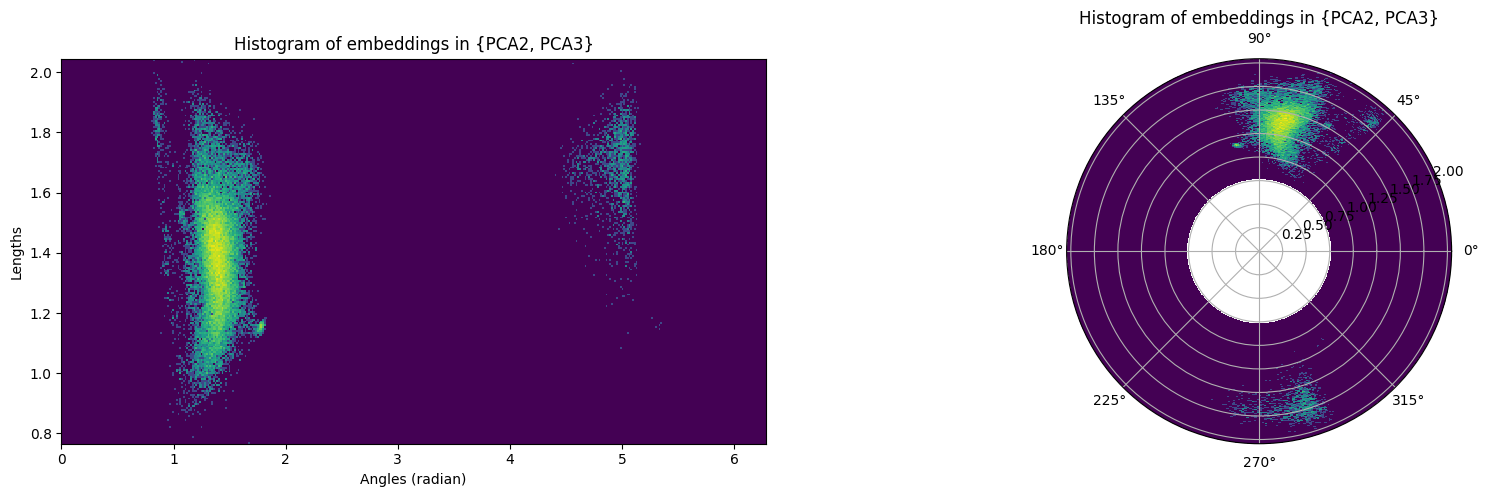

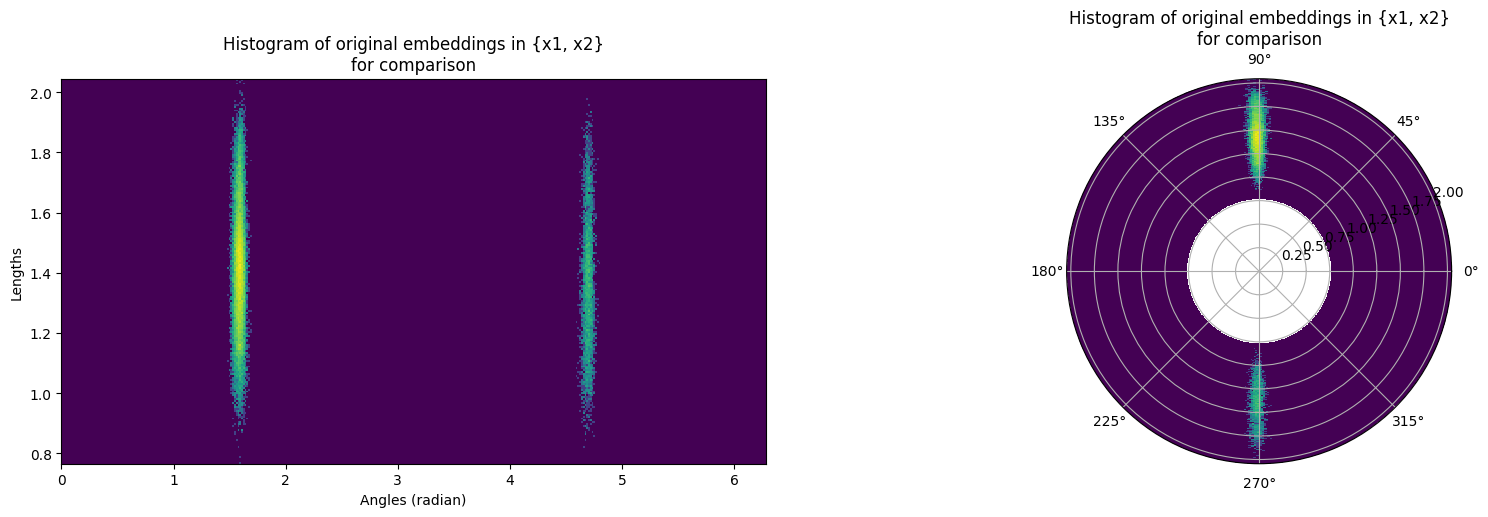

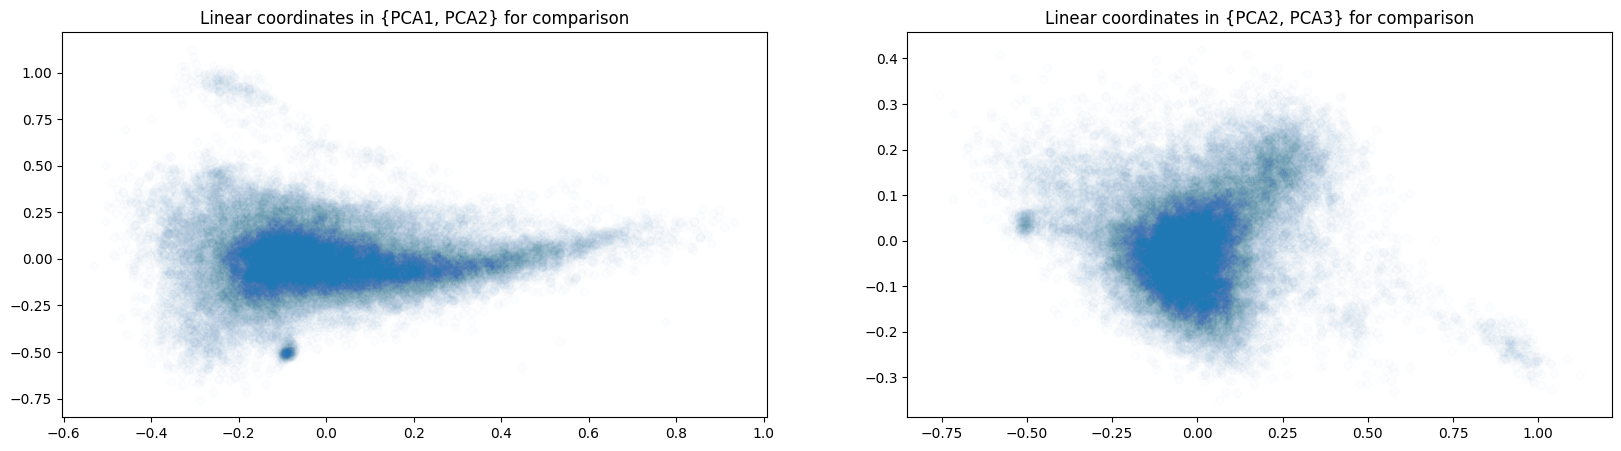

In [46]:
default_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = (20, 5)

space_center = np.zeros(embedding_matrix.shape[1])
embedding_lengths = embeddings2lengths(embedding_matrix, space_center)
embedding_angles = embeddings2angles(embedding_matrix, orthogonal_axes=pca.components_[:4])

draw_2d_histograms(embedding_lengths, embedding_angles[0], "Histogram of embeddings in {PCA1, PCA2}")
draw_2d_histograms(embedding_lengths, embedding_angles[1], "Histogram of embeddings in {PCA2, PCA3}")

orig_axis1 = np.zeros(embedding_matrix.shape[1])
orig_axis1[0] = 1
orig_axis2 = np.zeros(embedding_matrix.shape[1])
orig_axis2[1] = 1
orig_embedding_lengths = embeddings2lengths(embedding_matrix, space_center)
orig_embedding_angles = embeddings2angles(embedding_matrix, orthogonal_axes=np.vstack((orig_axis1, orig_axis2)))
draw_2d_histograms(orig_embedding_lengths, orig_embedding_angles[0], "Histogram of original embeddings in {x1, x2}\nfor comparison")

fig, axs = plt.subplots(1, 2)
pca_visual = PCA(n_components=3)
pca_representation = pca_visual.fit_transform(embedding_matrix)
axs[0].plot(pca_representation[:, 0], pca_representation[:, 1], 'o', alpha=0.01)
axs[0].set_title("Linear coordinates in {PCA1, PCA2} for comparison")
axs[1].plot(pca_representation[:, 1], pca_representation[:, 2], 'o', alpha=0.01)
axs[1].set_title("Linear coordinates in {PCA2, PCA3} for comparison")
plt.show()

plt.rcParams['figure.figsize'] = default_figsize

**Conclusion**

* Histograms in PCA coordinates are more informative than histograms in the original $\{x_1, x_2\}$ coordinates.
* Results in linear PCA coordinates look significantly different, compared to the one in generalized polar coordinates: no separation on two clouds is seen. But linear PCA centered and scaled the data, which makes comparison harder. Correctness of transformation can be checked on toy datasets.

### Check Visualization on Toy Datasets <a name="check_on_toy_datasets"></a>

To perform this check we adapt [scikit-learn example](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) with toy datasets.

In [47]:
# Generate datasets

n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=0)[0]
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)[0]
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)[0]
no_structure = np.random.rand(n_samples, 2)

# anisotropically distributed data
X, y = datasets.make_blobs(n_samples=n_samples, random_state=0)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=0)[0]

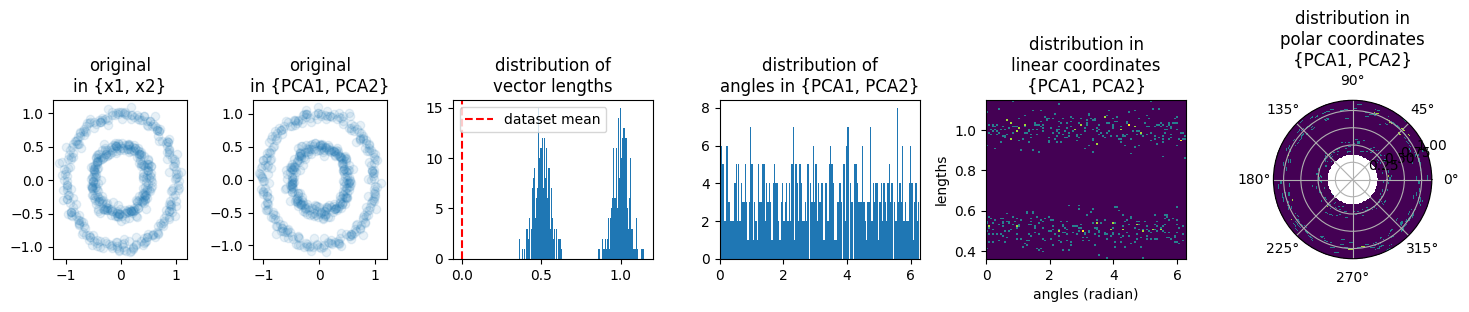

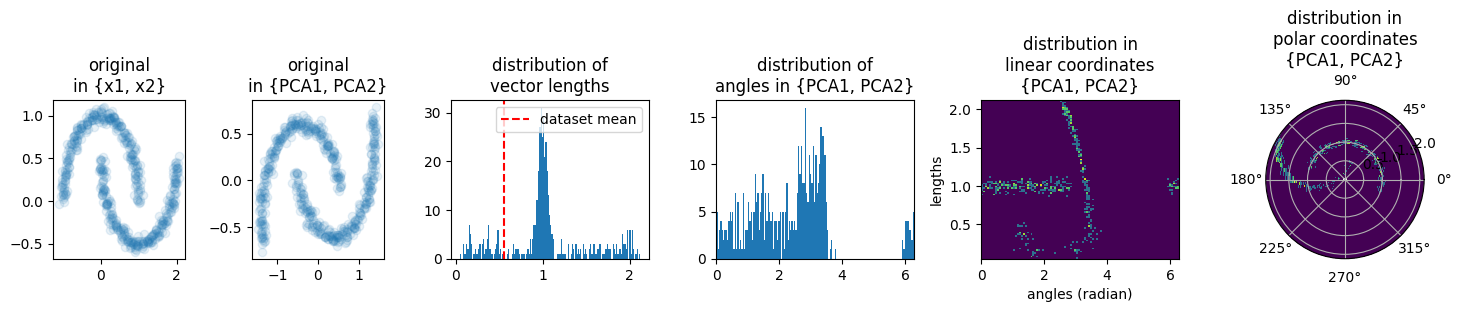

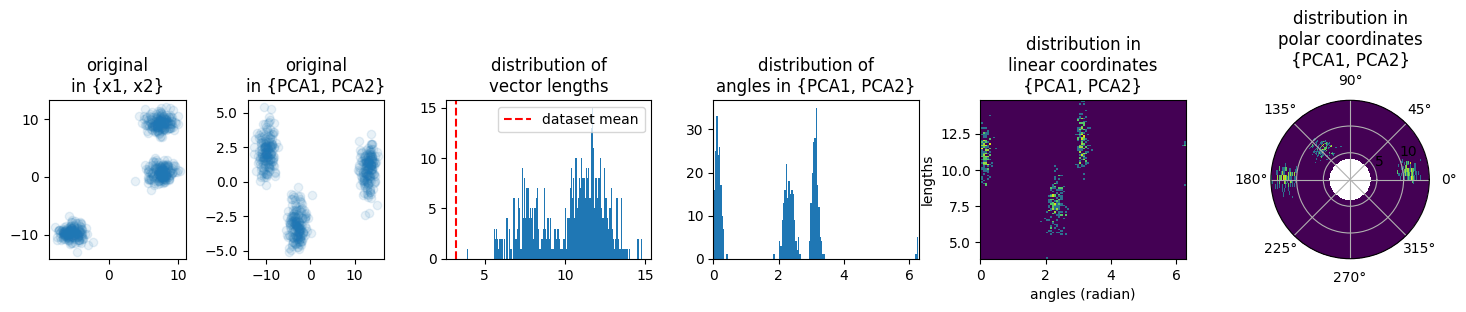

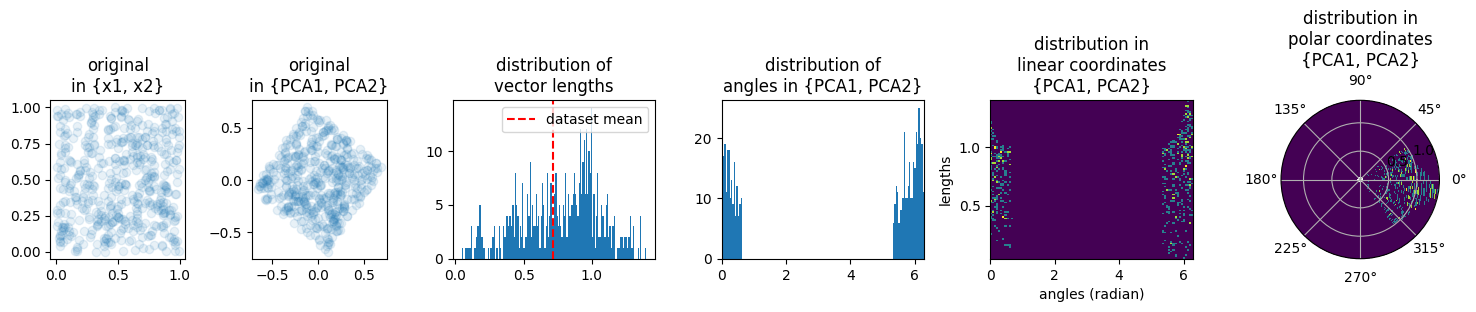

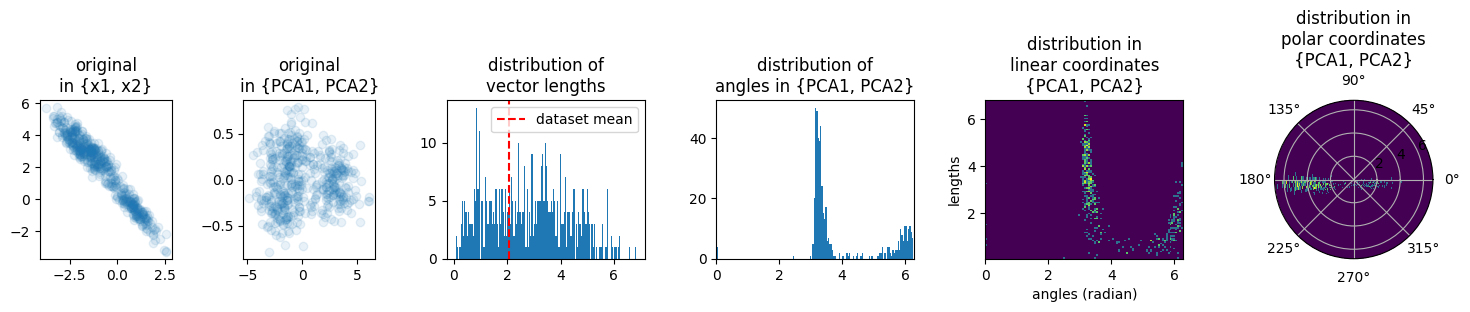

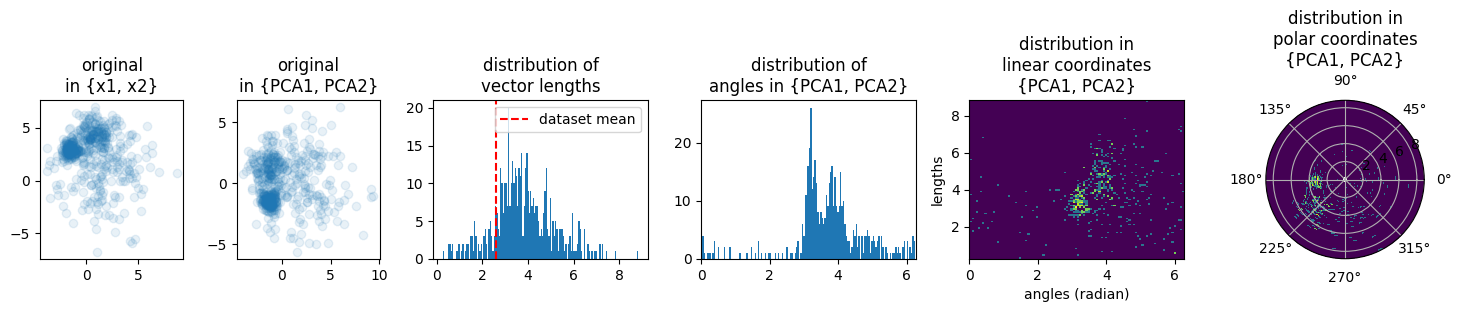

In [48]:
# Visualization

default_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = (40, 5)

model_datasets = [noisy_circles, noisy_moons, blobs, no_structure, aniso, varied]

for dataset in model_datasets:
    figure, axs = plt.subplots(1, 6, figsize=(15, 3), width_ratios=[1, 1, 1.5, 1.5, 1.5, 1.5])
    axs[0].plot(dataset[:, 0], dataset[:, 1], 'o', alpha=0.1)
    axs[0].set_title("original\nin {x1, x2}")

    pca_visual = PCA(n_components=min(3, dataset.shape[1]))
    pca_representation = pca_visual.fit_transform(dataset)
    axs[1].plot(pca_representation[:, 0], pca_representation[:, 1], 'o', alpha=0.1)
    axs[1].set_title("original\nin {PCA1, PCA2}")

    mean_vector = np.mean(dataset, axis=0)
    space_center = np.zeros(dataset.shape[1])
    embedding_lengths = embeddings2lengths(dataset, space_center)
    # arguments are passed to np.histogram
    axs[2].hist(embedding_lengths, bins=150)
    axs[2].set_title("distribution of\nvector lengths")
    mean_vector_length = embeddings2lengths([mean_vector], space_center)[0]
    axs[2].axvline(x=mean_vector_length, color='red', ls='--', label="dataset mean")
    axs[2].legend()

    pca_full = PCA(n_components=dataset.shape[1])
    pca_full.fit(dataset)
    embedding_angles = embeddings2angles(dataset, orthogonal_axes=pca_full.components_)
    axs[3].hist(embedding_angles[0], bins=150)
    axs[3].set_title("distribution of\nangles in {PCA1, PCA2}")
    axs[3].set_xlim((0, np.pi * 2))

    axs[4].hist2d(
        embedding_angles[0],
        embedding_lengths,
        bins=(100, 100),
        range=((0, 2*np.pi), (embedding_lengths.min(), embedding_lengths.max())),
        norm='symlog',
    )
    axs[4].set_xlabel("angles (radian)")
    axs[4].set_xlim((0, np.pi * 2))
    axs[4].set_ylabel("lengths")
    axs[4].set_title("distribution in\nlinear coordinates\n{PCA1, PCA2}")

    axs[5].axis('off')
    ax = plt.gcf().add_subplot(1, 6, 6, projection='polar')
    hist_vals, angles, lengths = np.histogram2d(
        embedding_angles[0],
        embedding_lengths,
        bins=(100, 100),
        range=((0, 2*np.pi), (embedding_lengths.min(), embedding_lengths.max())),
    )
    ax.pcolormesh(angles, lengths, hist_vals.transpose(), norm='symlog')
    ax.set_title("distribution in\npolar coordinates\n{PCA1, PCA2}")

    plt.tight_layout()
    plt.show()

plt.rcParams['figure.figsize'] = default_figsize

**Conclusion**

* Images in the original, PCA, and polar coordinates correspond to each other, no inconsistencies found in any distributions
* 2D histogram of lengths and angles in linear coordinates can be delusive about form of the clouds, so polar coordinates are preferable

### Visualize Clusters <a name="visualize_clusters"></a>

Finally, found clusters can be visualized in generalized polar coordinates.

In [49]:
def draw_2d_histograms_with_clusters(lengths, angles, cluster_elem_idxs, title, cluster_show_count, max_cluster_print_elems):
    default_figsize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = (20, 5)

    assert 2*cluster_show_count <= len(cluster_elem_idxs)
    print(f"================================ {cluster_show_count} biggest clusters: ================================")
    for i, cluster_elems in enumerate(cluster_elem_idxs[:cluster_show_count] + cluster_elem_idxs[-cluster_show_count:]):
        if i == cluster_show_count:
            print(f"================================ {cluster_show_count} smallest clusters: ================================")
        cluster_lengths = lengths[cluster_elems]
        cluster_angles = angles[cluster_elems]
        length_mean = cluster_lengths.mean()
        angle_mean = scipy.stats.circmean(cluster_angles)
        length_std = cluster_lengths.std()
        angle_std = scipy.stats.circstd(cluster_angles)
        cluster_txt = embeddings2tokens(embedding_matrix[cluster_elems[:max_cluster_print_elems]], knn_model)  # will work for any clusters
        if len(cluster_elems) > max_cluster_print_elems:
            cluster_str = f"<first {max_cluster_print_elems}> {cluster_txt}"
        else:
            cluster_str = f"{cluster_txt}"

        print(f"Plotting cluster (n={len(cluster_elems)}, {angle_std = :.2f}, {length_std = :.2f}): " + cluster_str)

        ax1, ax2 = draw_2d_histograms(lengths, angles, title, finalize_plot=False)

        ax1.scatter(cluster_angles, cluster_lengths, marker='o', color='orange')
        for elem_idx in range(min(len(cluster_elems), max_cluster_print_elems)):
            ax1.annotate(
                f"{word_to_plot_printable(cluster_txt[elem_idx])}",
                (cluster_angles[elem_idx] + 0.05, cluster_lengths[elem_idx]),
                color='orange',
            )

        ax2.scatter(cluster_angles, cluster_lengths, marker='o', color='orange')

        plt.show()

    plt.rcParams['figure.figsize'] = default_figsize

#### Clusters Found in the Original Space <a name="visualize_orig_clusters"></a>

We visualize only a few biggest and smallest clusters.

================================ 2 biggest clusters: ================================
Plotting cluster (n=5426, angle_std = 0.50, length_std = 0.19): <first 20> ['[PAD]', '[SEP]', '!', '"', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7']


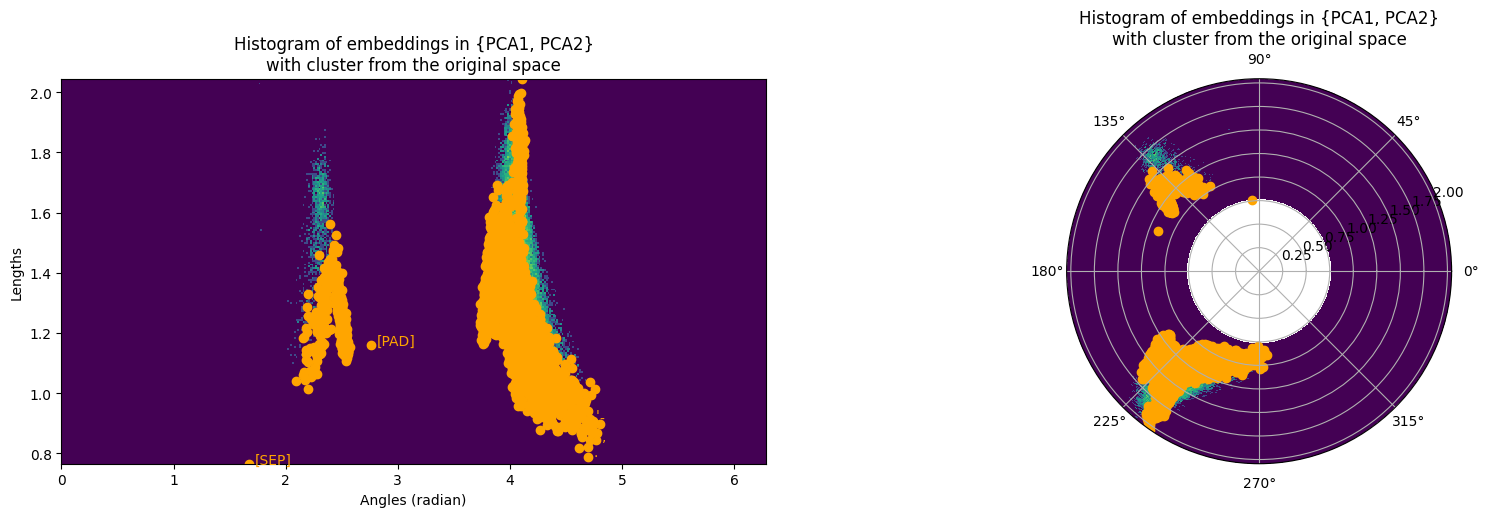

Plotting cluster (n=18, angle_std = 0.43, length_std = 0.08): ['years', 'year', 'season', 'days', 'months', 'week', 'minutes', 'hours', 'weeks', 'hour', 'month', 'minute', 'seconds', 'centuries', 'decades', 'moments', 'weekend', 'decade']


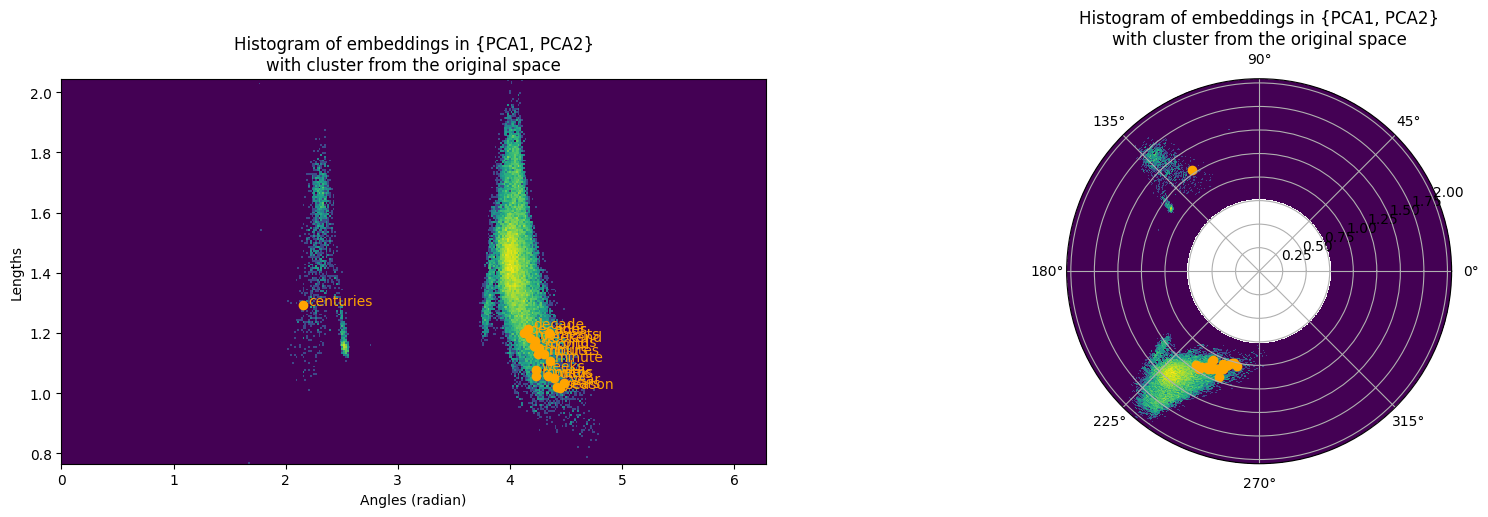

================================ 2 smallest clusters: ================================
Plotting cluster (n=4, angle_std = 0.07, length_std = 0.07): ['assist', 'assisted', 'assists', 'assisting']


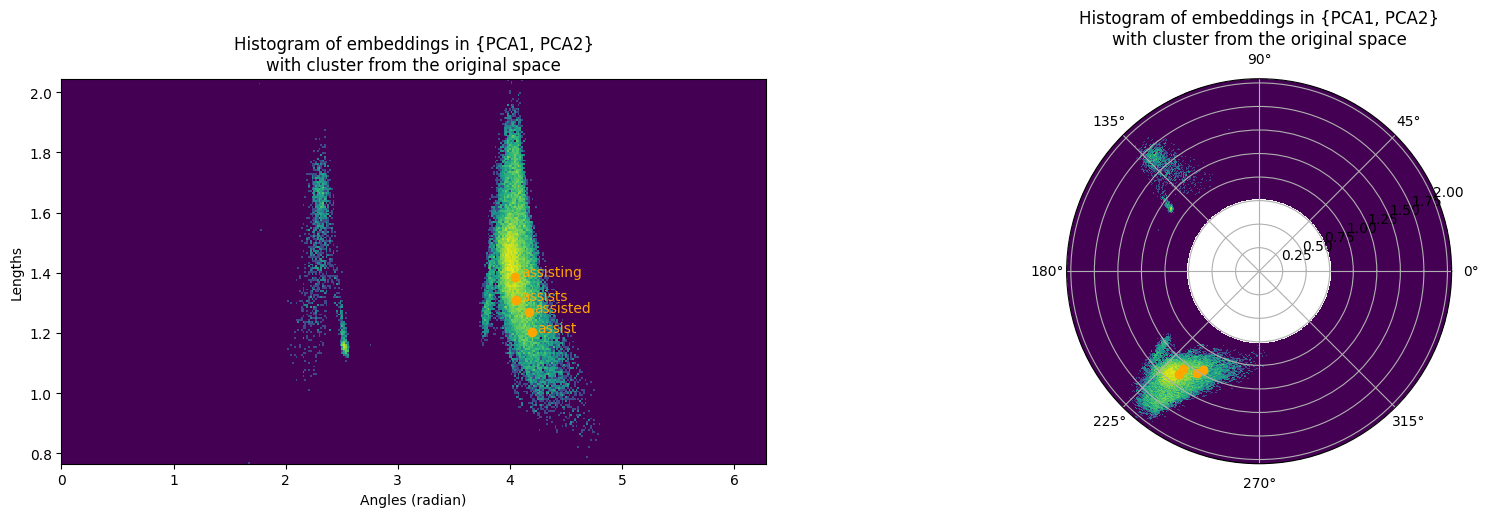

Plotting cluster (n=3, angle_std = 0.01, length_std = 0.09): ['comforting', 'soothing', 'calming']


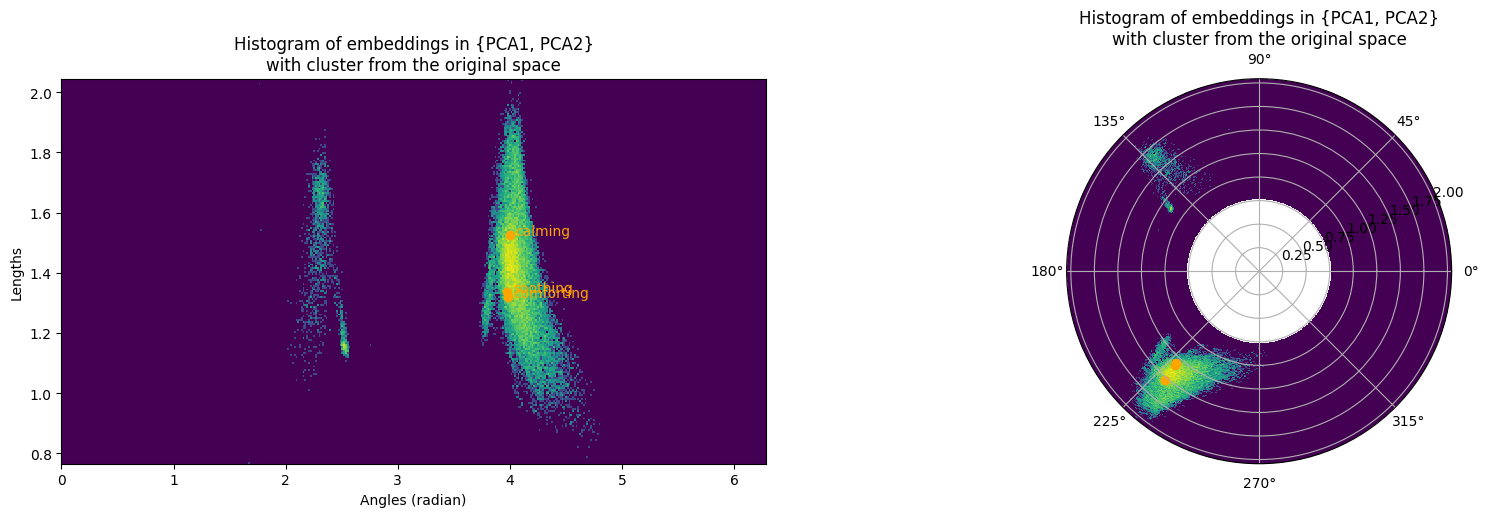

In [50]:
embedding_lengths = embeddings2lengths(embedding_matrix, np.zeros(embedding_matrix.shape[1]))
embedding_angles = embeddings2angles(embedding_matrix, orthogonal_axes=pca.components_[:2])

draw_2d_histograms_with_clusters(
    embedding_lengths,
    embedding_angles[0],
    cluster_elem_idxs,
    "Histogram of embeddings in {PCA1, PCA2}\nwith cluster from the original space",
    cluster_show_count=2,
    max_cluster_print_elems=20,
)

#### Clusters Found in t-SNE Reduced Space <a name="visualize_tsne_clusters"></a>

We visualize only a few biggest and smallest clusters.

================================ 2 biggest clusters: ================================
Plotting cluster (n=211, angle_std = 0.09, length_std = 0.19): <first 20> ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '000', '12', '15', '20', '18', '11', '30', '16', '14', '13']


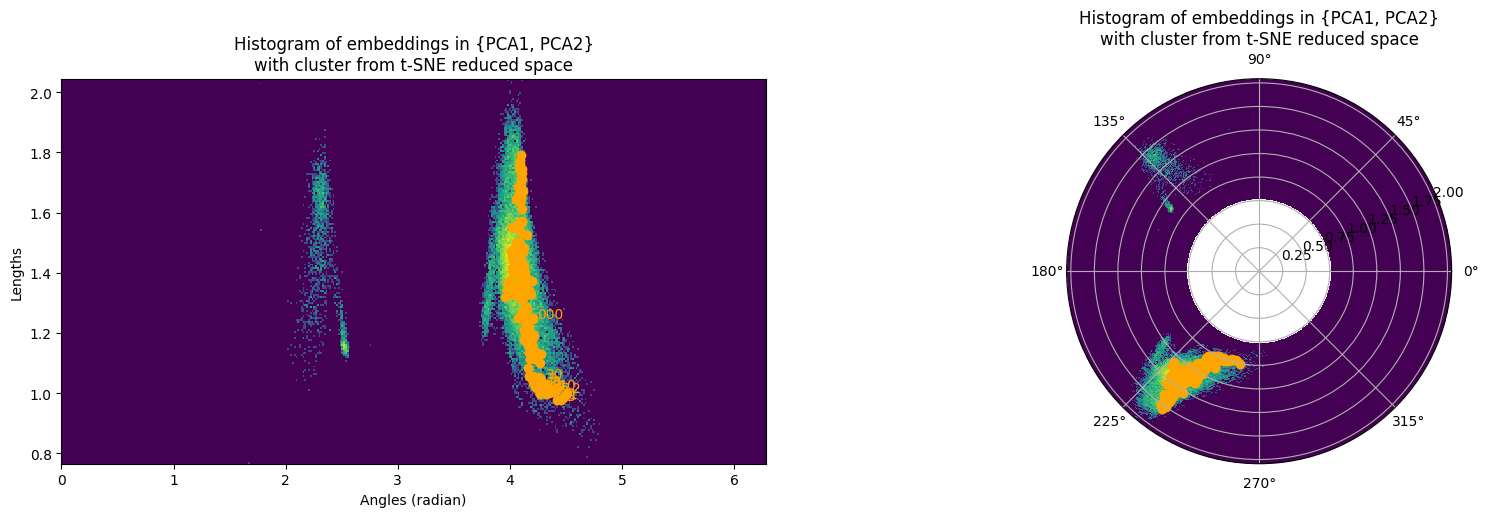

Plotting cluster (n=202, angle_std = 0.06, length_std = 0.15): <first 20> ['1990', '1989', '1988', '1987', '1986', '1985', '1984', '1980', '1983', '1982', '1979', '1981', '1972', '1976', '1978', '1974', '1975', '1977', '1970', '1968']


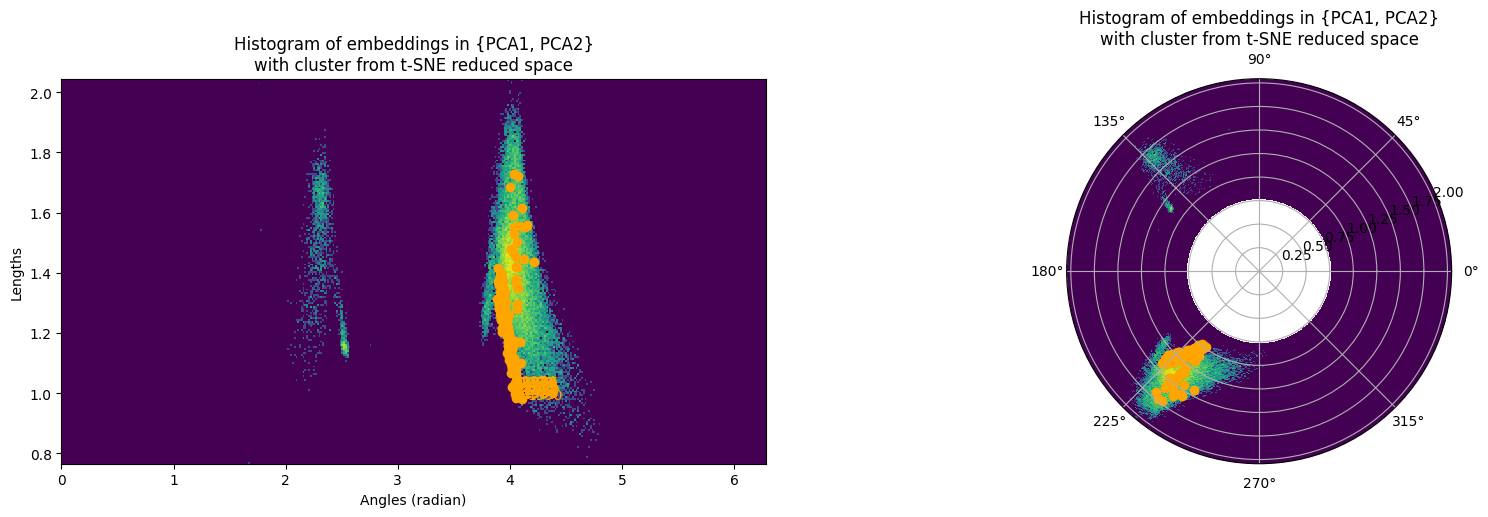

================================ 2 smallest clusters: ================================
Plotting cluster (n=2, angle_std = 0.04, length_std = 0.07): ['grimaced', 'neared']


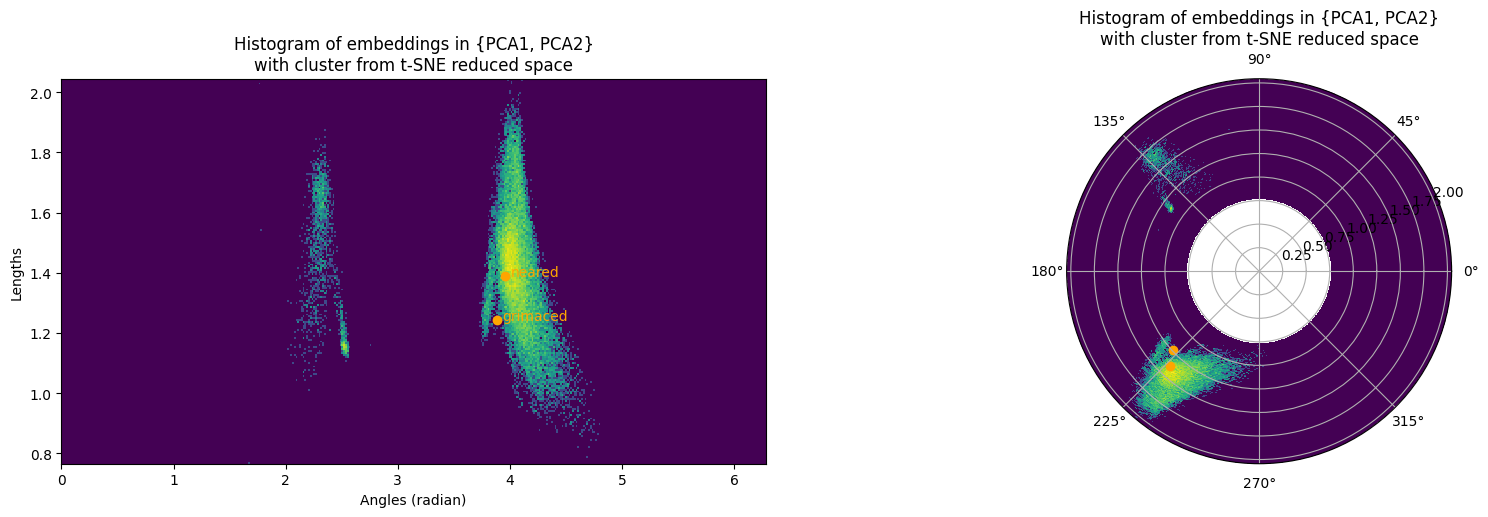

Plotting cluster (n=2, angle_std = 0.02, length_std = 0.03): ['##ᵣ', '##ₚ']


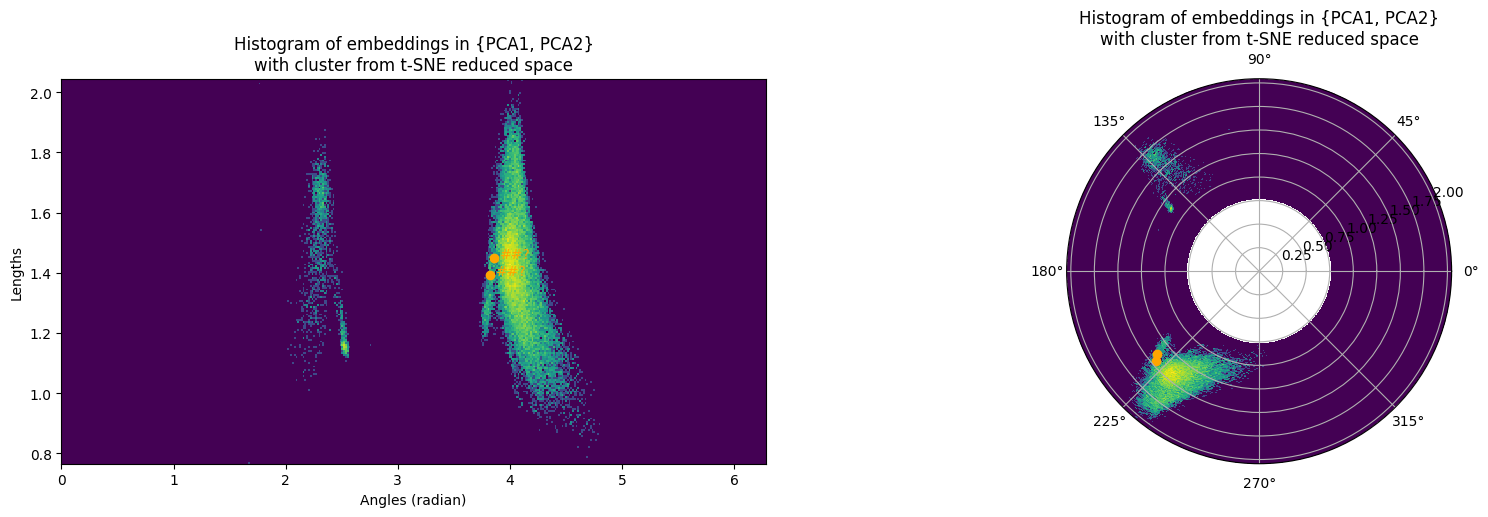

In [51]:
draw_2d_histograms_with_clusters(
    embedding_lengths,
    embedding_angles[0],
    tsne_cluster_elem_idxs,
    "Histogram of embeddings in {PCA1, PCA2}\nwith cluster from t-SNE reduced space",
    cluster_show_count=2,
    max_cluster_print_elems=20,
)

## Conclusions <a name="final_conclusions"></a>

1. Although some clusters can be found right in the original space, non-linear dimensionality reduction (like t-SNE) provides significantly more robust results: more clusters with more related elements
1. Facts about embedding space structure from visual analysis in generalized polar coordinates (not all plots are shown above for short):
   1. Clusters in generalized polar coordinates (both from the original and t-SNE spaces) don't appear to be located in particular areas. Some observations:
      1. Years are mostly located at the same area
      1. Numbers can be located in very different places
      1. Subwords also can be located in very different places
   1. Some clusters are located even in different clouds in {PCA1, PCA2} polar coordinates. This can mean that this projection shows a single cloud, which is reflected related to the origin.
1. Since words inside clusters are co-occurring in the same context, some of them have completely different meanings. Subsequent processing in BERT will need to apply additional transformations to distinguish them.

---

**Authors:** [Yury Yakhno](https://github.com/YuryYakhno), [Salih Dündar](https://github.com/salih1907), Orion Innovation, October 2023

---